# Air Pollution by Politics

## Imports & Installs

In [1]:
import os
import sys
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, explained_variance_score

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.signal import argrelextrema

sys.path.append('../etc')
from refs import state_abbreviation_dict

!pip install -q xlrd openpyxl

## Loads

Since the `data` folder is approximately **14 GB**, it has been uploaded to a **shared Google Drive folder**.
To access and use this data in this notebook, follow these steps:

---

### 1. Upload this notebook to **Google Colab**
- Open [Google Colab](https://colab.research.google.com/).
- Click on **File → Upload notebook** and select this notebook.

### 2. Mount your Google Drive
Insert and run the following code in a new Colab cell:

```python
from google.colab import drive
drive.mount('/content/drive')
```
- This will prompt you to authorize access to your Google Drive.

### 3. Create a Shortcut of the `data` Folder in Your Google Drive
- Open the shared Google Drive link.
- **Right-click** the `data` folder → **Add shortcut to Drive**.
- Choose a location inside your **MyDrive** (e.g., directly under "MyDrive" or inside a project folder).

### 4. Update the File Paths in the Notebook
When reading the data files, adjust the paths in your code to point to your shortcut location.
For example:

```python
import pandas as pd

# Example
presidential_data = pd.read_csv('/content/drive/MyDrive/your_folder_name/data/election/relevant/usa/1976-2020-president.csv')
```

Replace `your_folder_name` with the actual folder name where you added the shortcut.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# presidential_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2020-president.csv')
# senate_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2020-senate.csv')
# house_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2022-house.csv')
# house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')
#
# state_emissions_data = pd.read_excel(
#     "/content/drive/MyDrive/School/data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
#     engine="openpyxl",
#     skiprows=4
# )
#
# state_population_size_data = pd.read_csv('/content/drive/MyDrive/School/data/general_state_data/population_data.csv')
# state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
# state_land_size_data = pd.read_csv('/content/drive/MyDrive/School/data/general_state_data/state_sizes.csv')

In [4]:
presidential_data = pd.read_csv('../data/election/relevant/usa/1976-2020-president.csv')
senate_data = pd.read_csv('../data/election/relevant/usa/1976-2020-senate.csv')
house_data = pd.read_csv('../data/election/relevant/usa/1976-2022-house.csv')
house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')

state_emissions_data = pd.read_excel(
    "../data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
    engine="openpyxl",
    skiprows=4
)

state_population_size_data = pd.read_csv('../data/general_state_data/population_data.csv')
state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
state_land_size_data = pd.read_csv('../data/general_state_data/state_sizes.csv')

##  Analysis Per Category

### Election Analysis

This code calculates a political score for each U.S. state based on presidential, House, and Senate election data. It processes the election data for each year, calculates political scores by considering factors like vote percentage, longest streak of party wins, and the party of the most recent winner. It then combines these scores using weighted averages for each state and year. The final political scores are scaled and adjusted using the `MinMaxScaler`, and the scores are returned in a DataFrame, where each row represents a state’s political score for a specific year. This method provides insights into state-level political trends over time.

In [5]:
def calculate_scores_by_year(presidential_data, house_data, senate_data):
    years = sorted(presidential_data['year'].unique())
    all_scores = []

    for year in years:
        pres_results = calculate_political_scores(presidential_data, year)
        house_results = calculate_political_scores(house_data, year)
        sen_results = calculate_political_scores(senate_data, year)
        final_political_score = merge_and_average_scores(house_results, sen_results, pres_results, year)
        all_scores.append(final_political_score)

    return pd.concat(all_scores).reset_index(drop=True)

def calculate_political_scores(df, year=2020):
    df = df[df['year'] <= year].copy()  # Ensure a full copy is made
    df_filtered = df[df['party_simplified'].isin(['DEMOCRAT', 'REPUBLICAN'])].copy()

    df_filtered.loc[:, 'vote_percent'] = df_filtered['candidatevotes'] / df_filtered['totalvotes'] * 100

    df_winner = df_filtered.loc[df_filtered.groupby(['year', 'state'])['candidatevotes'].idxmax()].copy()

    state_streaks = {}
    for state in df_winner['state'].unique():
        state_data = df_winner[df_winner['state'] == state].sort_values('year')
        current_party = None
        streak = 0
        max_streak = 0
        last_winner = None

        for _, row in state_data.iterrows():
            if row['party_simplified'] == current_party:
                streak += 1
            else:
                current_party = row['party_simplified']
                streak = 1
            max_streak = max(max_streak, streak)
            last_winner = current_party

        state_streaks[state] = {'longest_streak': max_streak, 'last_winner': last_winner}

    df_summary = df_winner.groupby('state').agg(
        total_elections=('year', 'count'),
        avg_vote_percent=('vote_percent', 'mean'),
        last_winner=('party_simplified', 'last'),
        last_vote_percent=('vote_percent', 'last')
    ).reset_index()

    df_summary['longest_streak'] = df_summary['state'].map(lambda x: state_streaks[x]['longest_streak'])
    df_summary['streak_party'] = df_summary['state'].map(lambda x: state_streaks[x]['last_winner'])

    df_summary['party_numeric'] = df_summary['last_winner'].map({'REPUBLICAN': -1, 'DEMOCRAT': 1})

    features = df_summary[['longest_streak', 'avg_vote_percent', 'last_vote_percent']]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_summary.loc[:, ['streak_score', 'avg_vote_score', 'last_vote_score']] = scaler.fit_transform(features)

    df_summary['final_score'] = (df_summary['streak_score'] * 0.4 +
                                 df_summary['avg_vote_score'] * 0.3 +
                                 df_summary['last_vote_score'] * 0.3) * df_summary['party_numeric']
    df_summary['year'] = year
    return df_summary[['state', 'year', 'final_score']]

def merge_and_average_scores(house_results, sen_results, pres_results, year=2020):
    df_combined = house_results.merge(sen_results, on=['state', 'year'], suffixes=('_house', '_sen')) \
                               .merge(pres_results, on=['state', 'year'], suffixes=('', '_pres'))

    df_combined['final_score_avg'] = df_combined[['final_score_house', 'final_score_sen', 'final_score']].mean(axis=1)

    return df_combined[['state', 'year', 'final_score_avg']]

final_political_scores_by_year = calculate_scores_by_year(presidential_data, house_data, senate_data)
final_political_scores_by_year = final_political_scores_by_year.rename(columns={'final_score_avg':'party_affiliation_score'})
final_political_scores_by_year

,state,year,party_affiliation_score
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


### Emissions Analysis

This code analyzes state-level emissions data by excluding any rows containing "Total" in the state name. It then calculates the average emissions for each state across the available years and identifies the top 10 states with the highest and lowest average emissions. The results are visualized in two separate bar charts: one for the top 10 states with the highest emissions, and another for the top 10 states with the lowest emissions, using red and green colors, respectively. These plots help to easily identify and compare the states based on their average emissions over time.

In [6]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


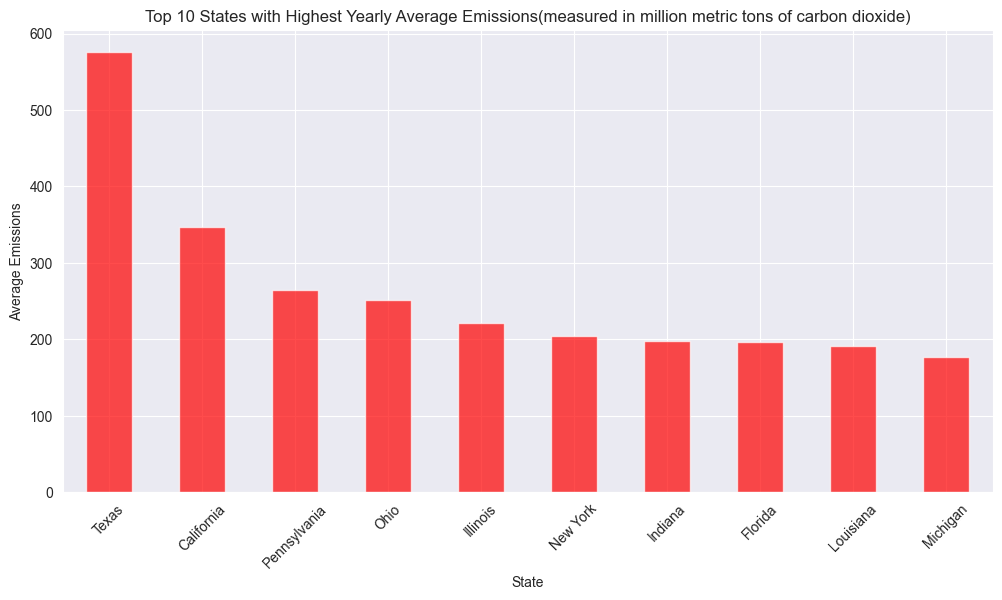

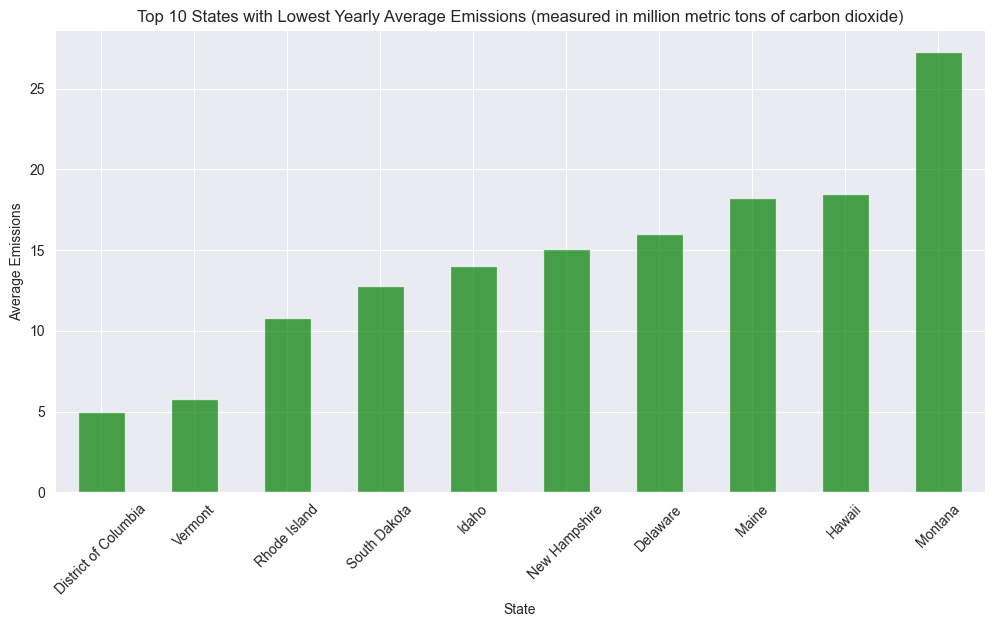

In [7]:
state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]
top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(10)
bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(10)

plt.figure(figsize=(12, 6))
top_states.plot(kind='bar', color='red', alpha=0.7)
plt.title("Top 10 States with Highest Yearly Average Emissions(measured in million metric tons of carbon dioxide)")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
bottom_states.plot(kind='bar', color='green', alpha=0.7)
plt.title("Top 10 States with Lowest Yearly Average Emissions (measured in million metric tons of carbon dioxide)")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

This code analyzes and visualizes emissions data alongside political scores for U.S. states. It first filters out rows containing "Total" in the state name and then identifies the top and bottom 10 states based on their average emissions over time. For each of these states, it detects local minima and maxima in emissions using the `argrelextrema` function. It then plots emissions data over time, marking the local extrema points with blue (minima) and red (maxima) markers, while displaying corresponding political scores at each point. The `plot_emissions_with_extrema` function is used to generate two separate plots: one for the top 10 states with the highest emissions and another for the bottom 10 states with the lowest emissions. Additionally, the `extract_state_name` function extracts the state name from a given directory path. This comprehensive analysis helps in understanding the trends in emissions in relation to political scores over time.

In [8]:
def extract_state_name(base_directory):
    return os.path.basename(base_directory)

In [9]:
def analyze_and_plot_emissions(state_emissions_data, political_scores_data):
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].isna()]
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Source:", na=False)]

    year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]
    top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(5).index
    bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(5).index

    top_states_data = state_emissions_data[state_emissions_data['State'].isin(top_states)].set_index('State')[year_columns].T
    bottom_states_data = state_emissions_data[state_emissions_data['State'].isin(bottom_states)].set_index('State')[year_columns].T

    def find_local_extrema(data):
        extrema = {}
        for state in data.columns:
            emissions = data[state].values
            years = data.index.values
            local_min_idx = argrelextrema(emissions, np.less)[0]  # Indices of local minima
            local_max_idx = argrelextrema(emissions, np.greater)[0]  # Indices of local maxima
            extrema[state] = {
                "min": [(years[i], emissions[i]) for i in local_min_idx],  # Store (year, emission) pairs for mins
                "max": [(years[i], emissions[i]) for i in local_max_idx]   # Store (year, emission) pairs for max
            }
        return extrema

    top_extrema = find_local_extrema(top_states_data)
    bottom_extrema = find_local_extrema(bottom_states_data)

    def plot_emissions_with_extrema(data, extrema, title, scores_data):
        plt.figure(figsize=(12, 6))

        for state in data.columns:
            plt.plot(data.index, data[state], label=state)

            for x, y in extrema[state]["min"]:
                plt.scatter(x, y, color='blue', marker='v', zorder=5)
                # Convert both state names to uppercase for comparison
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    # Display the Min label with party affiliation score
                    plt.text(x, y - 0.2, f"Min {score[0]:.2f}", fontsize=9, verticalalignment='bottom', horizontalalignment='center')
            for x, y in extrema[state]["max"]:
                plt.scatter(x, y, color='red', marker='^', zorder=5)
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    plt.text(x, y + 0.2, f"Max {score[0]:.2f}", fontsize=9, verticalalignment='top', horizontalalignment='center')

        plt.title(title)
        plt.xlabel("Year")
        plt.ylabel("Emissions")
        plt.legend(title="States", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_emissions_with_extrema(top_states_data, top_extrema, "Top 5 States with Highest Emissions Over Time", political_scores_data)
    plot_emissions_with_extrema(bottom_states_data, bottom_extrema, "Top 5 States with Lowest Emissions Over Time", political_scores_data)

In [10]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


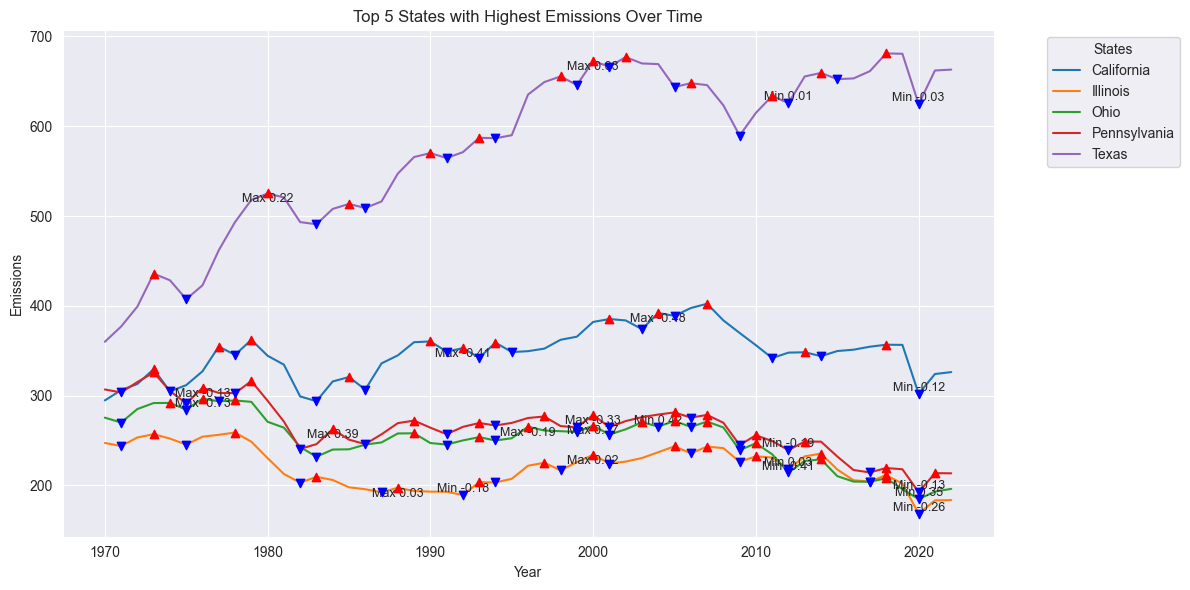

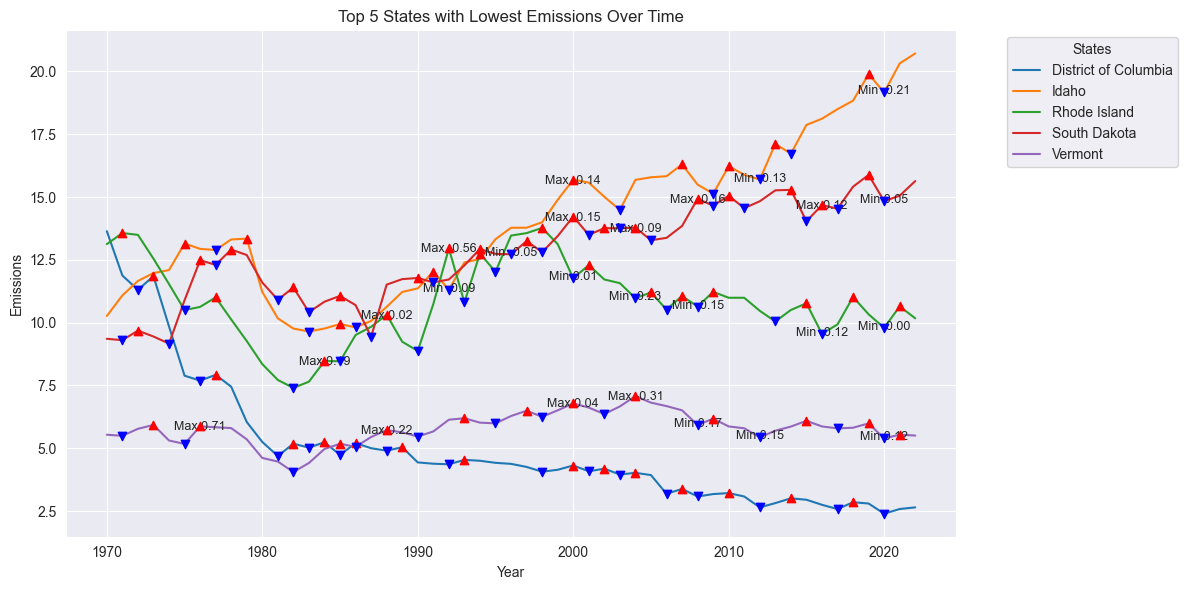

In [11]:
analyze_and_plot_emissions(state_emissions_data, final_political_scores_by_year)

### Demographic and Size Additions

This code performs data transformation and merging to create a comprehensive dataset for analysis. It starts by melting the `state_emissions_data` to reshape it, converting column names to lowercase and standardizing state names using a dictionary (`state_abbreviation_dict`). It then filters the data to include only valid years and merges it with `state_population_size_data` based on state and year. The `state_land_size_data` is also processed and merged to include land size information. Afterward, the political score data (`final_political_scores_by_year`) is integrated into the dataset by standardizing state names and performing another merge. The final result is a merged dataset (`final_merged_dataset`) containing emissions, population size, land size, and political scores for each state and year, ready for further analysis.

In [12]:
state_emissions_melted = state_emissions_data.melt(id_vars=["State"],
                                                   var_name="Year",
                                                   value_name="Emissions")
state_emissions_melted.columns = state_emissions_melted.columns.str.lower()
state_emissions_melted = state_emissions_melted.applymap(lambda x: x.lower() if isinstance(x, str) else x)

state_emissions_melted["state"] = state_emissions_melted["state"].map(state_abbreviation_dict)

state_emissions_melted["year"] = state_emissions_melted["year"].astype(str)
state_emissions_melted = state_emissions_melted.dropna(subset=["year"])  # Remove NaNs
state_emissions_melted = state_emissions_melted[state_emissions_melted["year"].str.isnumeric()]  # Keep only numeric years

state_emissions_melted["year"] = state_emissions_melted["year"].astype(int)
state_population_size_data["year"] = state_population_size_data["year"].astype(int)

merged_population_and_emission_data = state_emissions_melted.merge(state_population_size_data, on=["state", "year"], how="inner")

state_land_size_data = state_land_size_data.rename(columns={"State": "state"})
state_land_size_data["state"] = state_land_size_data["state"].str.lower().map(state_abbreviation_dict)

merged_size_population_emissions_data = merged_population_and_emission_data.merge(state_land_size_data, on="state", how="inner")
merged_size_population_emissions_data = merged_size_population_emissions_data.rename(columns={"Size (Square Miles)": "size"})

final_political_scores_by_year["state"] = final_political_scores_by_year["state"].str.lower().map(state_abbreviation_dict)

final_merged_dataset = merged_size_population_emissions_data.merge(final_political_scores_by_year, on=["state", "year"], how="inner")

final_merged_dataset

,state,year,emissions,population,size,party_affiliation_score
0,AL,1980,107.172609,3900368,52420,0.707140
1,AL,1984,95.389801,3951820,52420,0.365180
2,AL,1988,105.221571,4023844,52420,0.121370
3,AL,1992,120.975301,4139269,52420,0.225649
4,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...
578,WY,2004,64.383683,509106,97813,-0.206691
579,WY,2008,67.222540,546043,97813,-0.211750
580,WY,2012,66.647098,576656,97813,-0.260097
581,WY,2016,61.035090,585243,97813,-0.280461


### Bills Analysis

This code processes environmental bills and votes data across multiple directories to calculate a "Final Score" for each state and year. It begins by loading JSON files for bills and votes, normalizing and merging the data, and calculating the percentage of "yes" votes for each bill. The code identifies climate-related bills by checking for specific environmental terms in the bill description, calculates a weighted climate score based on vote percentages, and sums these scores to get the final score. The code is designed to process files for all states and years in a directory structure, aggregating the results into a final DataFrame. It also measures the execution time and saves the results to a CSV file. The final output provides a dataset of average "Final Scores" by year and state, reflecting the states' environmental legislative activity over time.

In [13]:
def process_bills_and_votes(bill_directory, vote_directory, environmental_terms):
    def load_json_files_from_directory(directory_path):
        data_list = []
        if os.path.exists(directory_path) and os.listdir(directory_path):
            for filename in os.listdir(directory_path):
                if filename.endswith(".json"):
                    with open(os.path.join(directory_path, filename), 'r') as file:
                        data = json.load(file)
                        df = pd.json_normalize(data)
                        data_list.append(df)
            return pd.concat(data_list, ignore_index=True) if data_list else pd.DataFrame()
        return pd.DataFrame()

    bill_df = load_json_files_from_directory(bill_directory)
    if bill_df.empty:
        return 0

    bill_df.columns = [col.split('.')[-1] for col in bill_df.columns]

    vote_df = load_json_files_from_directory(vote_directory)
    if vote_df.empty:
        return 0

    vote_df.columns = [col.split('.')[-1] for col in vote_df.columns]

    merged_df = pd.merge(bill_df, vote_df, on="bill_id", how="outer")
    merged_df = merged_df.drop_duplicates(subset='bill_id', keep='first')
    merged_df['percent_yes'] = merged_df['yea'] / merged_df['total']
    merged_df = merged_df[['percent_yes', 'bill_id', 'title', 'description']].reset_index().drop(columns=['index'])

    merged_df['climate'] = merged_df['description'].apply(lambda x: 1 if any(term.lower() in str(x).lower() for term in environmental_terms) else 0)
    merged_df.fillna(0)

    climate_ratio = merged_df['climate'].sum() / len(merged_df) if len(merged_df) > 0 else 0
    merged_df['weighted_climate'] = climate_ratio * merged_df['percent_yes']
    final_score = merged_df['weighted_climate'].sum()

    return final_score

def process_all_files(base_directory, environmental_terms):
    year = os.path.basename(base_directory).split('-')[0]
    file_dict = {}

    vote_dir = os.path.join(base_directory, 'vote')
    bill_dir = os.path.join(base_directory, 'bill')

    file_dict[year] = process_bills_and_votes(bill_dir, vote_dir, environmental_terms)

    df = pd.DataFrame(list(file_dict.items()), columns=['Year', 'Final_Score'])
    return df

def process_all_states(base_directory, environmental_terms):
    results = []
    for subdir in os.listdir(base_directory):
        subdir_path = os.path.join(base_directory, subdir)
        print(subdir_path)
        if os.path.isdir(subdir_path):
            subdirectory_df = process_all_files(subdir_path, environmental_terms)
            results.append(subdirectory_df)

    state = extract_state_name(base_directory)
    final_df = pd.concat(results, ignore_index=True)
    final_df['State'] = state
    return final_df

def process_all_directories(base_directory, environmental_terms):
    all_results = []
    state_count = 1

    for state_dir in os.listdir(base_directory):
        print(f"{state_count}: Processing state: {state_dir}")
        state_count+=1
        state_dir_path = os.path.join(base_directory, state_dir)

        if os.path.isdir(state_dir_path):
            state_df = process_all_states(state_dir_path, environmental_terms)
            all_results.append(state_df)

    final_df = pd.concat(all_results, ignore_index=True)
    final_df = final_df.sort_values('Year').reset_index().drop(columns=['index'])
    final_df = final_df.groupby(['Year', 'State'])['Final_Score'].mean().reset_index()

    return final_df

def process_all_directories_timed(base_directory, environmental_terms):
    start_time = time.time()

    results_df = process_all_directories(base_directory, environmental_terms)

    end_time = time.time()
    execution_time = end_time - start_time
    results_df.to_csv('data/results/election_scores.csv')
    print(f"Execution Time: {execution_time} seconds")

    return results_df

In [14]:
# DON'T RUN - TAKES HOURS TO TERMINATE
# results_df = process_all_directories_timed('data/bills', environmental_terms)
# results_df

This code processes the election scores data by reading a CSV file and cleaning the data by removing unnecessary columns and sorting by year and state. It then maps state abbreviations using a dictionary (`state_abbreviation_dict`). The data is grouped into four-year periods (starting from 2008), and the policy scores for each state are aggregated by summing the "Final_Score" within each year group. The resulting DataFrame is renamed to "Policy Scores" and contains aggregated scores by year group and state.

In [15]:
election_scores_df = pd.read_csv('../data/results/election_scores.csv')
election_scores_df = election_scores_df.drop(columns=['Unnamed: 0'])
election_scores_df = election_scores_df.sort_values(by=['Year', 'State'], ascending=True)
election_scores_df['State'] = election_scores_df['State'].map(state_abbreviation_dict)

start_year = 2008
election_scores_df['Year_Group'] = (election_scores_df['Year'] - start_year) // 4 * 4 + start_year
aggregated_scores_df = election_scores_df.groupby(['Year_Group', 'State'], as_index=False)['Final_Score'].sum()
aggregated_scores_df = aggregated_scores_df.rename(columns={'Final_Score': 'Policy Scores'})
aggregated_scores_df

,Year_Group,State,Policy Scores
0,2004,OH,0.000000
1,2004,PA,0.000000
2,2008,AK,0.000000
3,2008,AL,1.972585
4,2008,AR,23.282568
...,...,...,...
163,2024,TN,11.959624
164,2024,UT,1.664631
165,2024,VT,0.018692
166,2024,WA,14.846776


This code merges the `aggregated_scores_df` with `final_merged_dataset` based on matching year groups and states, using a right join to ensure all records from `final_merged_dataset` are included. It then drops the columns "State" and "Year_Group" and resets the index, cleaning up the final DataFrame. The resulting `final_df` contains the combined data with the aggregated policy scores and corresponding values from the merged dataset.

In [16]:
final_df = aggregated_scores_df.merge(final_merged_dataset,
                                       left_on=['Year_Group', 'State'],
                                       right_on=['year', 'state'],
                                       how='right')
final_df = final_df.drop(columns=['State', 'Year_Group']).reset_index().drop(columns='index')
final_df

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
0,NaN,AL,1980,107.172609,3900368,52420,0.707140
1,NaN,AL,1984,95.389801,3951820,52420,0.365180
2,NaN,AL,1988,105.221571,4023844,52420,0.121370
3,NaN,AL,1992,120.975301,4139269,52420,0.225649
4,NaN,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...,...
578,NaN,WY,2004,64.383683,509106,97813,-0.206691
579,3.146390,WY,2008,67.222540,546043,97813,-0.211750
580,14.832834,WY,2012,66.647098,576656,97813,-0.260097
581,12.360478,WY,2016,61.035090,585243,97813,-0.280461


This code identifies the numerical and categorical columns in the `final_df` DataFrame by selecting columns with `float64` and `int64` data types for numerical columns, and excluding them for categorical columns. It then applies a K-Nearest Neighbors (KNN) imputer to fill any missing values in the numerical columns, using 5 neighbors to estimate the missing data. The imputed values are applied to a copy of `final_df`, resulting in a new DataFrame (`final_df_imputed`) with the missing numerical data filled in.

In [17]:
numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = final_df.select_dtypes(exclude=['float64', 'int64']).columns

imputer = SimpleImputer(strategy='mean')

final_df_imputed = final_df.copy()
final_df_imputed[numerical_columns] = imputer.fit_transform(final_df_imputed[numerical_columns])

final_df_dropped = final_df.dropna(axis=0)

In [18]:
final_df_imputed

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
0,24.412201,AL,1980.0,107.172609,3900368.0,52420.0,0.707140
1,24.412201,AL,1984.0,95.389801,3951820.0,52420.0,0.365180
2,24.412201,AL,1988.0,105.221571,4023844.0,52420.0,0.121370
3,24.412201,AL,1992.0,120.975301,4139269.0,52420.0,0.225649
4,24.412201,AL,1996.0,137.217372,4290403.0,52420.0,0.015759
...,...,...,...,...,...,...,...
578,24.412201,WY,2004.0,64.383683,509106.0,97813.0,-0.206691
579,3.146390,WY,2008.0,67.222540,546043.0,97813.0,-0.211750
580,14.832834,WY,2012.0,66.647098,576656.0,97813.0,-0.260097
581,12.360478,WY,2016.0,61.035090,585243.0,97813.0,-0.280461


In [19]:
final_df_dropped

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
7,1.972585,AL,2008,139.355377,4718206,52420,-0.108467
8,11.211519,AL,2012,122.438181,4816632,52420,0.056473
9,10.323113,AL,2016,113.418599,4866824,52420,-0.118678
10,5.094120,AL,2020,97.977476,5033094,52420,-0.215275
18,0.000000,AK,2008,39.079214,687455,665384,0.072105
...,...,...,...,...,...,...,...
570,4.397349,WI,2020,86.643133,5897375,65496,-0.268129
579,3.146390,WY,2008,67.222540,546043,97813,-0.211750
580,14.832834,WY,2012,66.647098,576656,97813,-0.260097
581,12.360478,WY,2016,61.035090,585243,97813,-0.280461


In [20]:
def fill_missing_years(df):
    df['year'] = df['year'].astype(int)
    max_year = min(df['year'].max(), 2024)
    full_years = pd.DataFrame({'year': range(df['year'].min(), max_year + 1)})
    states = df['state'].unique()
    filled_df = []

    for state in states:
        state_df = df[df['state'] == state]
        state_df = pd.merge(full_years, state_df, on='year', how='left')
        state_df['state'] = state
        for col in ['Policy Scores', 'emissions', 'population', 'size', 'party_affiliation_score']:
            state_df[col] = state_df[col].interpolate(method='linear', limit_direction='both')
        filled_df.append(state_df)

    return pd.concat(filled_df).reset_index(drop=True)

In [21]:
final_df_imputed = fill_missing_years(final_df_imputed)
final_df_imputed

,year,Policy Scores,state,emissions,population,size,party_affiliation_score
0,1976,24.412201,AL,107.172609,3900368.0,52420.0,0.707140
1,1977,24.412201,AL,107.172609,3900368.0,52420.0,0.707140
2,1978,24.412201,AL,107.172609,3900368.0,52420.0,0.707140
3,1979,24.412201,AL,107.172609,3900368.0,52420.0,0.707140
4,1980,24.412201,AL,107.172609,3900368.0,52420.0,0.707140
...,...,...,...,...,...,...,...
2245,2016,12.360478,WY,61.035090,585243.0,97813.0,-0.280461
2246,2017,10.618073,WY,59.622609,583352.5,97813.0,-0.287553
2247,2018,8.875667,WY,58.210128,581462.0,97813.0,-0.294644
2248,2019,7.133262,WY,56.797646,579571.5,97813.0,-0.301735


In [22]:
final_df_dropped = fill_missing_years(final_df_dropped)
final_df_dropped

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,Policy Scores,state,emissions,population,size,party_affiliation_score
0,2004,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
1,2005,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
2,2006,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
3,2007,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
4,2008,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
...,...,...,...,...,...,...,...
624,2016,12.360478,WY,61.035090,585243.0,97813.0,-0.280461
625,2017,10.618073,WY,59.622609,583352.5,97813.0,-0.287553
626,2018,8.875667,WY,58.210128,581462.0,97813.0,-0.294644
627,2019,7.133262,WY,56.797646,579571.5,97813.0,-0.301735


#### Prepare Full Data

This code creates a copy of the `final_df_imputed` DataFrame and applies standardization to the selected columns. It first identifies the columns to normalize by excluding "state," "year," and "emissions" from the list of columns. Then, it uses the `StandardScaler` from `sklearn.preprocessing` to normalize these columns, transforming them to have a mean of 0 and a standard deviation of 1. The transformed data is assigned back to the corresponding columns in the `final_df_imputed` DataFrame, resulting in the normalized dataset.

In [23]:
def normalize_data(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    scaler = StandardScaler()
    columns_to_normalize = [col for col in df.columns if col not in exclude_columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

final_df_imputed_normalized = normalize_data(final_df_imputed)
final_df_dropped_normalized = normalize_data(final_df_dropped)

In [24]:
state_emissions_melted = state_emissions_melted.dropna()
state_emissions_melted

,state,year,emissions
0,AL,1970,102.717308
1,AK,1970,11.358988
2,AZ,1970,24.937739
3,AR,1970,36.238491
4,CA,1970,294.672829
...,...,...,...
2854,VA,2022,96.233942
2855,WA,2022,74.701895
2856,WV,2022,79.179688
2857,WI,2022,90.591835


In [25]:
final_df_imputed_normalized = final_df_imputed_normalized.copy()
final_df_imputed_normalized.set_index(['state', 'year'], inplace=True)
state_emissions_melted.set_index(['state', 'year'], inplace=True)

final_df_imputed_normalized['emissions'] = state_emissions_melted['emissions']

final_df_imputed_normalized.reset_index(inplace=True)
state_emissions_melted.reset_index(inplace=True)
final_df_imputed_normalized

,state,year,Policy Scores,emissions,population,size,party_affiliation_score
0,AL,1976,0.008907,108.123429,-0.260609,-0.244045,0.707140
1,AL,1977,0.008907,111.715385,-0.260609,-0.244045,0.707140
2,AL,1978,0.008907,106.665665,-0.260609,-0.244045,0.707140
3,AL,1979,0.008907,111.618240,-0.260609,-0.244045,0.707140
4,AL,1980,0.008907,107.172609,-0.260609,-0.244045,0.707140
...,...,...,...,...,...,...,...
2245,WY,2016,-0.696744,61.035090,-0.808000,0.227085,-0.280461
2246,WY,2017,-0.798765,62.583762,-0.808312,0.227085,-0.287553
2247,WY,2018,-0.900786,63.639323,-0.808624,0.227085,-0.294644
2248,WY,2019,-1.002807,58.897673,-0.808936,0.227085,-0.301735


In [26]:
final_df_dropped_normalized = final_df_dropped_normalized.copy()
final_df_dropped_normalized.set_index(['state', 'year'], inplace=True)
state_emissions_melted.set_index(['state', 'year'], inplace=True)

final_df_dropped_normalized['emissions'] = state_emissions_melted['emissions']

final_df_dropped_normalized.reset_index(inplace=True)
state_emissions_melted.reset_index(inplace=True)

final_df_dropped_normalized

,state,year,Policy Scores,emissions,population,size,party_affiliation_score
0,AL,2004,-0.576684,141.975194,-0.227362,-0.297275,-0.108467
1,AL,2005,-0.576684,143.531689,-0.227362,-0.297275,-0.108467
2,AL,2006,-0.576684,145.768689,-0.227362,-0.297275,-0.108467
3,AL,2007,-0.576684,147.286933,-0.227362,-0.297275,-0.108467
4,AL,2008,-0.576684,139.355377,-0.227362,-0.297275,-0.108467
...,...,...,...,...,...,...,...
624,WY,2016,-0.279498,61.035090,-0.788170,0.120018,-0.280461
625,WY,2017,-0.329346,62.583762,-0.788426,0.120018,-0.287553
626,WY,2018,-0.379194,63.639323,-0.788683,0.120018,-0.294644
627,WY,2019,-0.429043,58.897673,-0.788939,0.120018,-0.301735


Emissions initially declined, then rose steadily until the early 2000s, after which they began a continuous downward trend.

    year   emissions
0   1976   93.737515
1   1977   96.500934
2   1978   97.334440
3   1979   98.717193
4   1980   95.144842
5   1981   92.723631
6   1982   87.861297
7   1983   87.467112
8   1984   91.930208
9   1985   91.999663
10  1986   92.058266
11  1987   95.078238
12  1988   99.671862
13  1989  101.144680
14  1990  100.327565
15  1991   99.386259
16  1992  101.288180
17  1993  103.182156
18  1994  104.600861
19  1995  105.889315
20  1996  109.851460
21  1997  111.294663
22  1998  111.974872
23  1999  113.261021
24  2000  117.117254
25  2001  114.923910
26  2002  115.624927
27  2003  117.050857
28  2004  119.010031
29  2005  119.520495
30  2006  117.968544
31  2007  119.772586
32  2008  115.888839
33  2009  107.629638
34  2010  111.463404
35  2011  108.664135
36  2012  104.260472
37  2013  106.744099
38  2014  107.855380
39  2015  104.798473
40  2016  102.938219
41  2017  102.237081
42  2018  105.286101
43  2019  102.639411
44  2020   91.391576


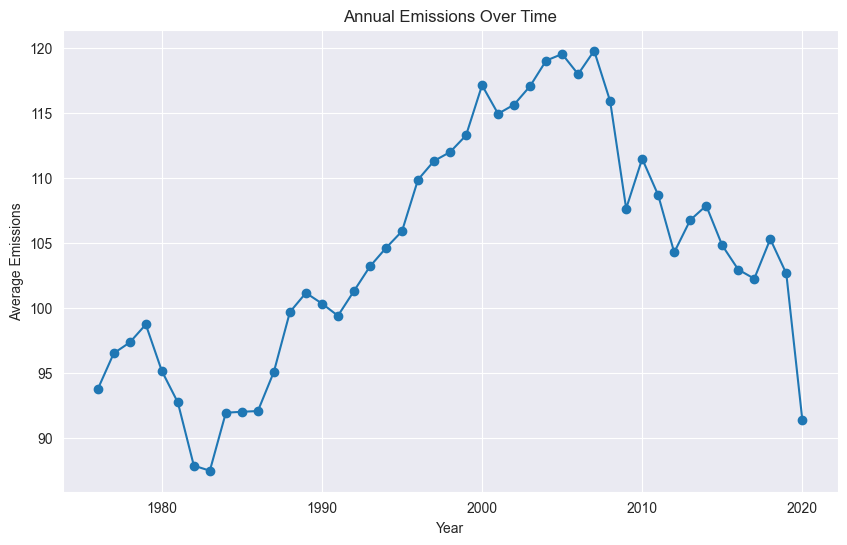

In [27]:
emissions_by_year = final_df_imputed_normalized.groupby('year')['emissions'].mean().reset_index()
print(emissions_by_year)
plt.figure(figsize=(10, 6))
plt.plot(emissions_by_year['year'], emissions_by_year['emissions'], marker='o')
plt.title('Annual Emissions Over Time')
plt.xlabel('Year')
plt.ylabel('Average Emissions')
plt.grid(True)
plt.show()

Average absolute change in national emissions year-over-year: 2.4745
Average total emissions per year: 104.3380
Change as percentage of average total emissions: 2.37%


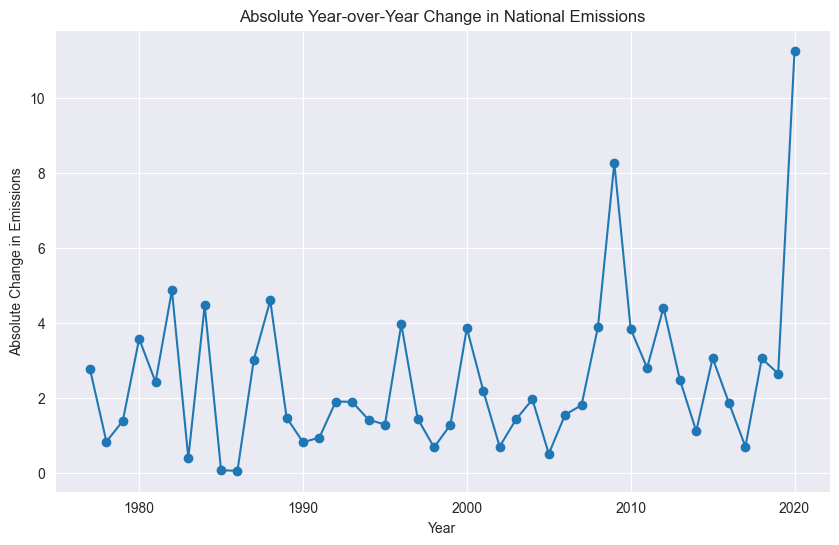

In [28]:
overall_yearly_mean = final_df_imputed_normalized.groupby('year')['emissions'].mean().rename('overall_mean')

overall_yearly_mean = overall_yearly_mean.sort_index()
yearly_changes = overall_yearly_mean.diff().dropna()
average_yearly_change = yearly_changes.abs().mean()
average_total_emissions = overall_yearly_mean.mean()
change_percentage = (average_yearly_change / average_total_emissions) * 100

print(f"Average absolute change in national emissions year-over-year: {average_yearly_change:.4f}")
print(f"Average total emissions per year: {average_total_emissions:.4f}")
print(f"Change as percentage of average total emissions: {change_percentage:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(yearly_changes.index, yearly_changes.abs(), marker='o')
plt.title('Absolute Year-over-Year Change in National Emissions')
plt.xlabel('Year')
plt.ylabel('Absolute Change in Emissions')
plt.grid(True)
plt.show()


#### Final Results

In [29]:
# Final dataframes are:
#   1. final_df_dropped_normalized
#   2. final_df_dropped
#   3. final_df_imputed_normalized
#   4. final_df_imputed

## Final Analysis

### Current Emissions Predictions

In [30]:
def train_lr_model(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    label_encoder = LabelEncoder()
    df['political_party'] = label_encoder.fit_transform(df['party_affiliation_score'])

    state_columns = df.columns[6:]
    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score'] + list(state_columns)]
    y = df['emissions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    test_states = df.loc[y_test.index, 'state']

    start_time = time.time()
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)
    elapsed_time = time.time() - start_time

    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': lr_model.coef_
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    print(f'Mean Squared Error: {mse}')
    print(f'R² Score: {r2}')
    print(f'Time taken: {elapsed_time} seconds')
    print(f'Explained Variance Score: {explained_var}')

    print("\nFeature Coefficients:")
    print(coef_df)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), "r--", label='Regression Line')
    plt.xlabel('Actual Emissions')
    plt.ylabel('Predicted Emissions')
    plt.title('Linear Regression: Actual vs Predicted Emissions')
    plt.legend()
    plt.grid(True)
    plt.show()

    test_results = pd.DataFrame({
        'state': test_states,
        'actual': y_test,
        'predicted': y_pred
    })

    r2_by_state = test_results.groupby('state').apply(lambda g: r2_score(g['actual'], g['predicted']))
    stratified_r2 = r2_by_state.mean()

    print(f"\nStratified R² (average across states): {stratified_r2}")
    print(f"Highest R² by state: {r2_by_state.idxmax()} ({r2_by_state.max()})")
    print(f"Lowest R² by state: {r2_by_state.idxmin()} ({r2_by_state.min()})")

    plt.figure(figsize=(12, 6))
    r2_by_state.sort_values(ascending=False).plot(kind='bar')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('R² by State (Stratified)')
    plt.xlabel('State')
    plt.ylabel('R² Score')
    plt.tight_layout()
    plt.show()

    return mse, r2, elapsed_time, coef_df, stratified_r2, r2_by_state.sort_values(ascending=False)


#### Imputed

Mean Squared Error: 2844.6953231776215
R² Score: 0.7697657357480376
Time taken: 0.0051190853118896484 seconds
Explained Variance Score: 0.7698902734774242

Feature Coefficients:
                   Feature  Coefficient
1               population    91.012820
0            Policy Scores   -16.011503
2                     size     9.762727
3  party_affiliation_score     0.230568
4  party_affiliation_score     0.230568
5          political_party     0.020048


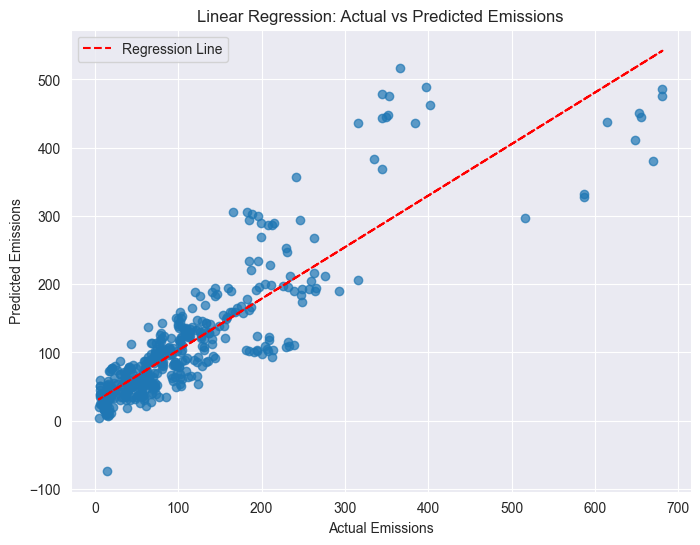


Stratified R² (average across states): -120.45645541495009
Highest R² by state: UT (0.2788992950977417)
Lowest R² by state: VT (-4549.022257892895)


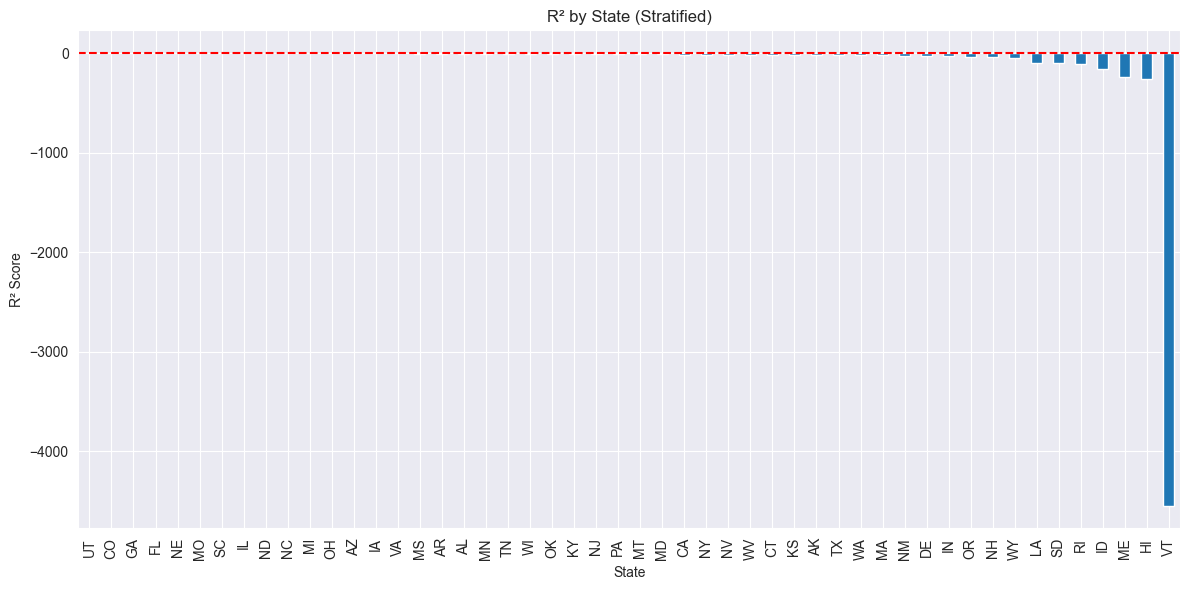

In [31]:
mse_imputed, r2_imputed, elapsed_time_imputed, feature_importance_imputed, stratified_r2_imputed, r2_by_state_imputed = train_lr_model(final_df_imputed_normalized)


#### Non-imputed

Mean Squared Error: 2676.9127154990324
R² Score: 0.7090988186404662
Time taken: 0.0042307376861572266 seconds
Explained Variance Score: 0.7129061339630184

Feature Coefficients:
                   Feature  Coefficient
1               population   125.916407
4  party_affiliation_score   -84.027910
3  party_affiliation_score   -84.027910
0            Policy Scores   -38.602481
2                     size     7.706794
5          political_party     0.331015


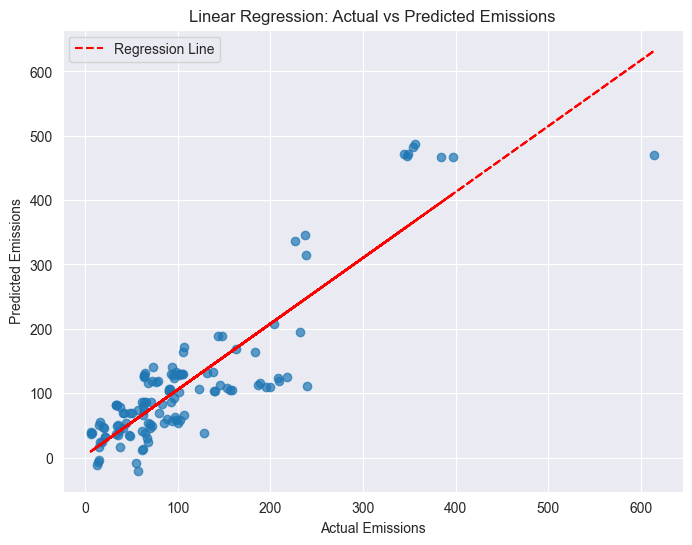


Stratified R² (average across states): -1416.2250324075171
Highest R² by state: CO (-0.009818641217546498)
Lowest R² by state: VA (-18510.284954959745)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


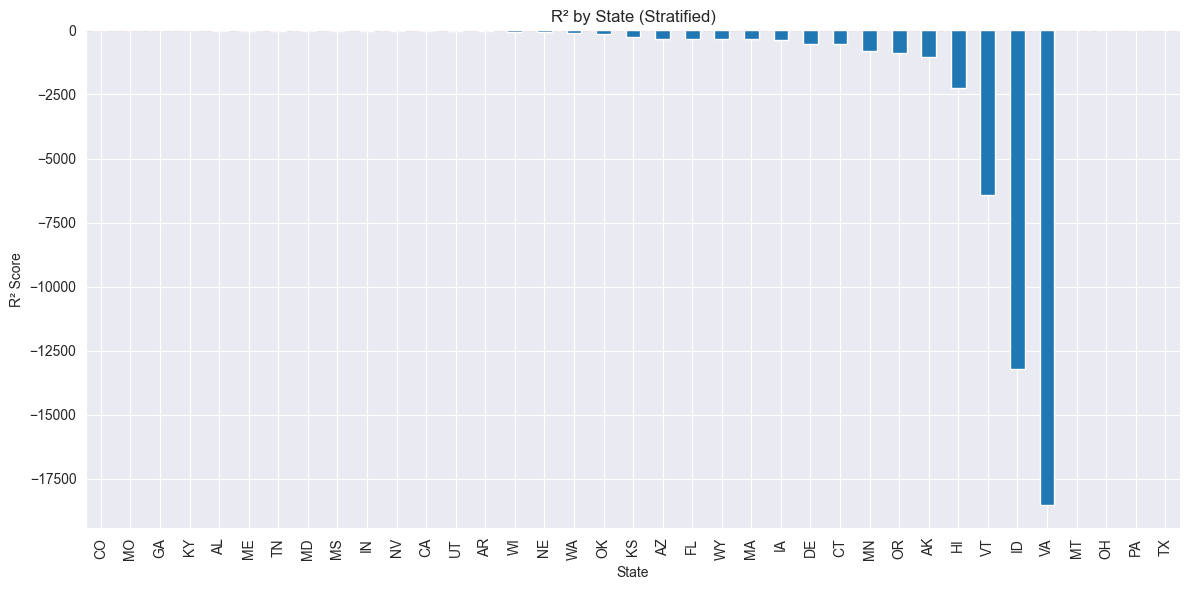

In [32]:
mse_imputed, r2_imputed, elapsed_time_imputed, feature_importance_imputed, stratified_r2_imputed, r2_by_state_imputed = train_lr_model(final_df_dropped_normalized)

This code trains a Random Forest model to predict emissions using various features such as "Policy Scores," "population," "size," "party_affiliation_score," and state-specific columns. It splits the data into training and testing sets, trains the model, and makes predictions on the test set. The Mean Squared Error (MSE) is calculated to evaluate the model's performance, and the execution time of the process is also recorded and printed. The final output includes the MSE and the time taken to train and test the model.

#### Un-Regularized

In [33]:
def train_rf_model_default(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    label_encoder = LabelEncoder()
    df['political_party'] = label_encoder.fit_transform(df['party_affiliation_score'])

    state_columns = df.columns[6:]
    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score'] + list(state_columns)]
    y = df['emissions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    test_states = df.loc[y_test.index, 'state']

    rf_model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )

    start_time = time.time()
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    elapsed_time = time.time() - start_time

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)

    feature_importance = rf_model.feature_importances_
    features = X.columns
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R² Score: {r2:.4f}')
    print(f'Explained Variance Score: {explained_var}')
    print(f'Time taken: {elapsed_time:.4f} seconds')

    print("\nFeature Importance:")
    print(feature_importance_df)

    test_results = pd.DataFrame({
        'state': test_states,
        'actual': y_test,
        'predicted': y_pred
    })

    r2_by_state = test_results.groupby('state').apply(lambda g: r2_score(g['actual'], g['predicted']))
    stratified_r2 = r2_by_state.mean()

    print(f"\nStratified R² (average across states): {stratified_r2}")
    print(f"Highest R² by state: {r2_by_state.idxmax()} ({r2_by_state.max()})")
    print(f"Lowest R² by state: {r2_by_state.idxmin()} ({r2_by_state.min()})")

    plt.figure(figsize=(12, 6))
    r2_by_state.sort_values(ascending=False).plot(kind='bar')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('R² by State (Stratified)')
    plt.xlabel('State')
    plt.ylabel('R² Score')
    plt.tight_layout()
    plt.show()

    return mse, r2, elapsed_time, feature_importance_df, stratified_r2, r2_by_state.sort_values(ascending=False)


##### Imputed

Mean Squared Error: 48.6633
R² Score: 0.9960
Explained Variance Score: 0.995999277209465
Time taken: 0.3468 seconds

Feature Importance:
                   Feature  Importance
1               population    0.740402
2                     size    0.250048
5          political_party    0.002588
3  party_affiliation_score    0.002407
4  party_affiliation_score    0.002379
0            Policy Scores    0.002175

Stratified R² (average across states): 0.5795962236619712
Highest R² by state: NE (0.9892276896735995)
Lowest R² by state: WY (-3.5290797565392715)


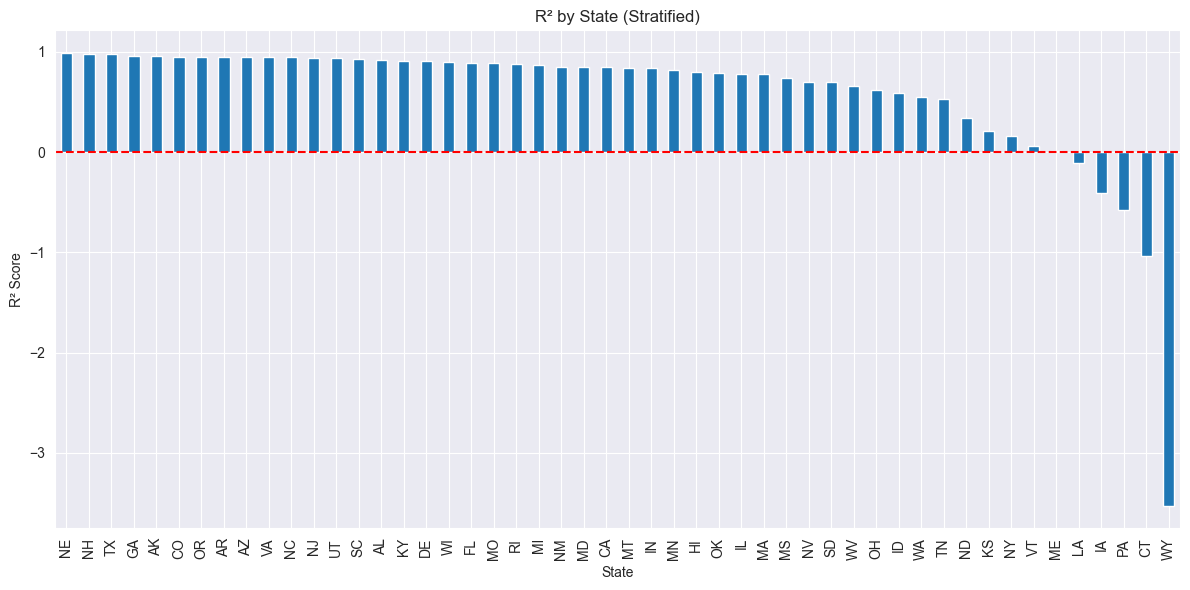

In [34]:
mse_rf, r2_rf, elapsed_time_rf, feature_importance_rf, stratified_r2_rf, r2_by_state_rf = train_rf_model_default(final_df_imputed)


##### Un-imputed

Mean Squared Error: 17.4913
R² Score: 0.9981
Explained Variance Score: 0.99808025932731
Time taken: 0.2372 seconds

Feature Importance:
                   Feature  Importance
1               population    0.883169
2                     size    0.079224
0            Policy Scores    0.020792
3  party_affiliation_score    0.007490
5          political_party    0.006419
4  party_affiliation_score    0.002906

Stratified R² (average across states): -2.2737122763538267
Highest R² by state: HI (0.9996129460459192)
Lowest R² by state: IA (-42.70785041280124)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


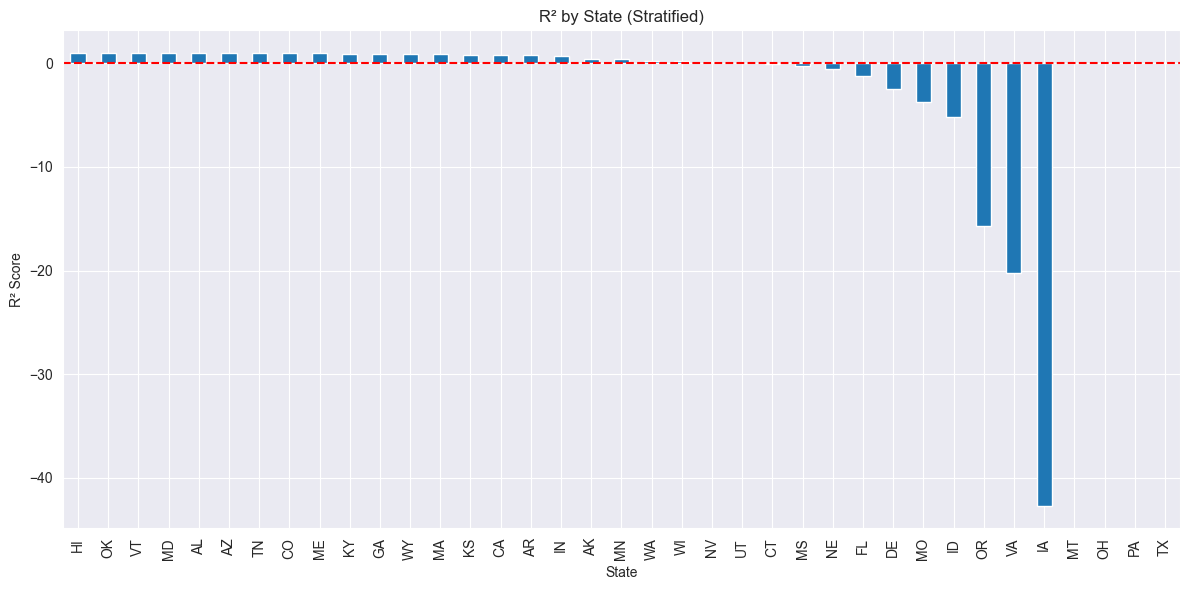

In [35]:
mse_rf, r2_rf, elapsed_time_rf, feature_importance_rf, stratified_r2_rf, r2_by_state_rf = train_rf_model_default(final_df_dropped)

### Regularized

In [36]:
def train_rf_model(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    label_encoder = LabelEncoder()
    df['political_party'] = label_encoder.fit_transform(df['party_affiliation_score'])

    state_columns = df.columns[6:]
    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score'] + list(state_columns)]
    y = df['emissions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    test_states = df.loc[y_test.index, 'state']

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1
    )

    start_time = time.time()
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    elapsed_time = time.time() - start_time

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)

    feature_importance = rf_model.feature_importances_
    features = X.columns
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R² Score: {r2:.4f}')
    print(f'Explained Variance Score: {explained_var}')
    print(f'Time taken: {elapsed_time:.4f} seconds')

    print("\nFeature Importance:")
    print(feature_importance_df)

    test_results = pd.DataFrame({
        'state': test_states,
        'actual': y_test,
        'predicted': y_pred
    })

    r2_by_state = test_results.groupby('state').apply(lambda g: r2_score(g['actual'], g['predicted']))
    stratified_r2 = r2_by_state.mean()

    print(f"\nStratified R² (average across states): {stratified_r2}")
    print(f"Highest R² by state: {r2_by_state.idxmax()} ({r2_by_state.max()})")
    print(f"Lowest R² by state: {r2_by_state.idxmin()} ({r2_by_state.min()})")

    plt.figure(figsize=(12, 6))
    r2_by_state.sort_values(ascending=False).plot(kind='bar')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('R² by State (Stratified)')
    plt.xlabel('State')
    plt.ylabel('R² Score')
    plt.tight_layout()
    plt.show()

    return mse, r2, elapsed_time, feature_importance_df, stratified_r2, r2_by_state.sort_values(ascending=False)


##### Imputed

Mean Squared Error: 277.8838
R² Score: 0.9771
Explained Variance Score: 0.9771486412336784
Time taken: 0.2386 seconds

Feature Importance:
                   Feature  Importance
1               population    0.749546
2                     size    0.246233
0            Policy Scores    0.001264
5          political_party    0.001017
4  party_affiliation_score    0.000978
3  party_affiliation_score    0.000962

Stratified R² (average across states): -2.936894198948134
Highest R² by state: TX (0.934305729257832)
Lowest R² by state: SD (-32.57133378905481)


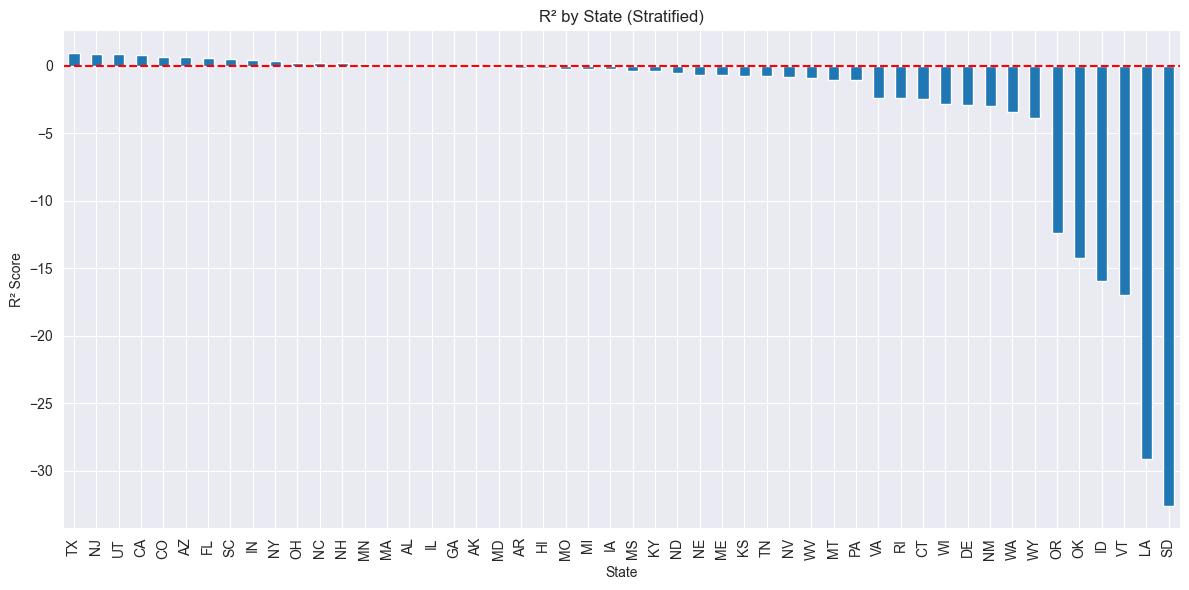

In [37]:
mse_rf, r2_rf, elapsed_time_rf, feature_importance_rf, stratified_r2_rf, r2_by_state_rf = train_rf_model(final_df_imputed)

##### Non-imputed

Mean Squared Error: 127.6250
R² Score: 0.9859
Explained Variance Score: 0.985926311547655
Time taken: 0.2374 seconds

Feature Importance:
                   Feature  Importance
1               population    0.890889
2                     size    0.079321
0            Policy Scores    0.018341
5          political_party    0.005737
4  party_affiliation_score    0.003186
3  party_affiliation_score    0.002526

Stratified R² (average across states): -6543.104029144333
Highest R² by state: MD (0.7488320804018749)
Lowest R² by state: ID (-211038.46293979962)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


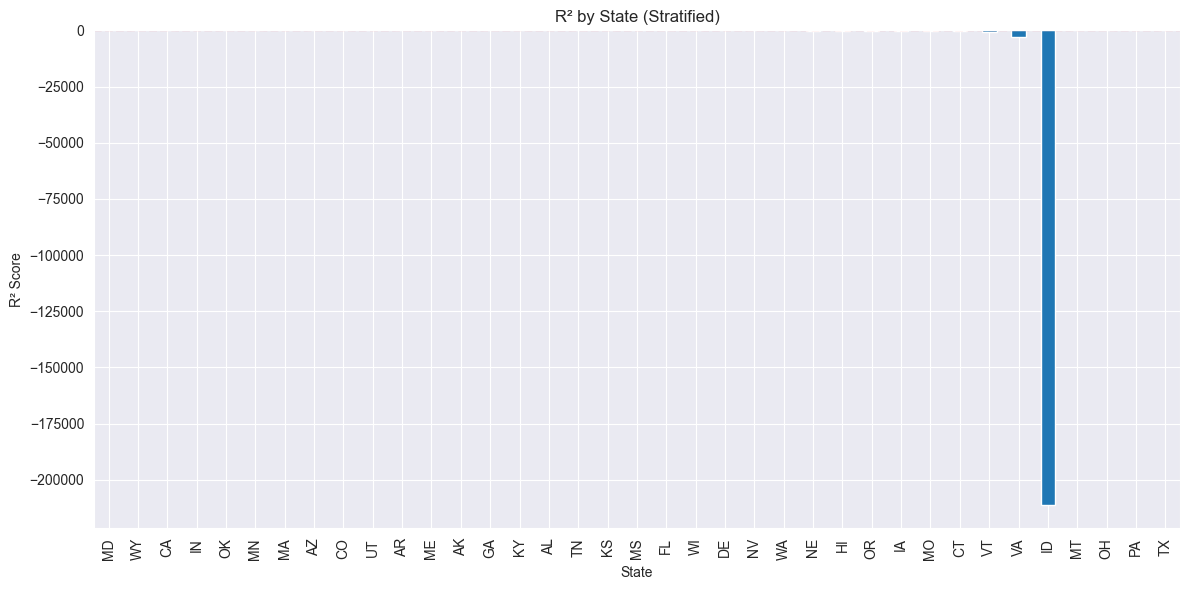

In [38]:
mse_rf, r2_rf, elapsed_time_rf, feature_importance_rf, stratified_r2_rf, r2_by_state_rf = train_rf_model(final_df_dropped)

This code trains a Linear Regression model to predict emissions using features such as "Policy Scores," "population," "size," "party_affiliation_score," and state-specific columns. The dataset is divided into training and testing sets, and the model is fitted using the training data. After generating predictions on the test set, the Mean Squared Error (MSE) and R² score are calculated to assess the model’s accuracy. The time taken to train and evaluate the model is also recorded. Additionally, the model's feature coefficients are displayed, and a plot is generated showing the actual vs. predicted emissions, including a red regression line to visualize the fit.

In [39]:
def analyze_top_states_by_r2(r2_by_state, df, model, top_k=10):
    top_states = r2_by_state.sort_values(ascending=False).head(top_k).index.tolist()
    feature_importance_dict = {}
    all_emissions_trend = {}
    all_mean_emissions = {}
    all_party_score = {}

    for state in df['state'].unique():
        df_state = df[df['state'] == state].copy()
        if len(df_state) < 10:
            continue

        label_encoder = LabelEncoder()
        df_state['political_party'] = label_encoder.fit_transform(df_state['party_affiliation_score'])

        state_columns = df_state.columns[6:]
        all_features = ['Policy Scores', 'population', 'size', 'party_affiliation_score'] + list(state_columns)
        all_features = list(dict.fromkeys(all_features))  # remove duplicates while preserving order
        X_state = df_state[all_features]
        y_state = df_state['emissions']

        if state in top_states:
            model.fit(X_state, y_state)
            importances = model.feature_importances_
            features = X_state.columns
            feature_importance_dict[state] = pd.Series(importances, index=features)

        df_state_sorted = df_state.sort_values(by='year')
        annual_changes = df_state_sorted['emissions'].diff().dropna()
        avg_change = annual_changes.abs().mean()
        all_emissions_trend[state] = avg_change
        all_mean_emissions[state] = df_state['emissions'].mean()
        all_party_score[state] = df_state['party_affiliation_score'].mean()

    combined = pd.DataFrame(feature_importance_dict).T
    mean_importance = combined.mean().sort_values(ascending=False)

    print(f"\nTop {top_k} states by R²: {top_states}")
    print("\nAverage Feature Importance Across Top States:")
    print(mean_importance)

    plt.figure(figsize=(10, 6))
    mean_importance.head(10).plot(kind='bar')
    plt.title(f"Top Predictive Features (Avg. over Top {top_k} States)")
    plt.ylabel("Mean Feature Importance")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    full_trend_df = pd.DataFrame({
        'Avg_Annual_Emission_Change': all_emissions_trend,
        'Mean_Emissions': all_mean_emissions,
        'Avg_Party_Score': all_party_score
    })

    top_trend_df = full_trend_df.loc[top_states]

    plt.figure(figsize=(10, 6))
    top_trend_df['Avg_Annual_Emission_Change'].plot(kind='bar')
    plt.title('Average Annual Emission Change (Top R² States)')
    plt.ylabel('Avg. Year-over-Year Emission Change')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    top_trend_df['Mean_Emissions'].plot(kind='bar', color='orange')
    plt.title('Mean Emissions (Top R² States)')
    plt.ylabel('Mean Annual Emissions')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    for state in full_trend_df.index:
        color = 'red' if state in top_states else 'blue'
        plt.scatter(
            full_trend_df.loc[state, 'Avg_Party_Score'],
            full_trend_df.loc[state, 'Mean_Emissions'],
            color=color,
            label=state if state in top_states else None
        )
    plt.xlabel('Average Party Affiliation Score')
    plt.ylabel('Mean Annual Carbon Emissions')
    plt.title('Political Affiliation vs. Mean Carbon Emissions (All States)')
    plt.axhline(0, linestyle='--', color='gray')
    plt.grid(True)

    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    if unique_labels:
        plt.legend(unique_labels.values(), unique_labels.keys(), title="Top R² States", loc='best')

    plt.tight_layout()
    plt.show()

    return mean_importance, full_trend_df.sort_values('Avg_Annual_Emission_Change')


Mean Squared Error: 48.6633
R² Score: 0.9960
Explained Variance Score: 0.995999277209465
Time taken: 0.3481 seconds

Feature Importance:
                   Feature  Importance
1               population    0.740402
2                     size    0.250048
5          political_party    0.002588
3  party_affiliation_score    0.002407
4  party_affiliation_score    0.002379
0            Policy Scores    0.002175

Stratified R² (average across states): 0.579596223661971
Highest R² by state: NE (0.9892276896735994)
Lowest R² by state: WY (-3.5290797565392715)


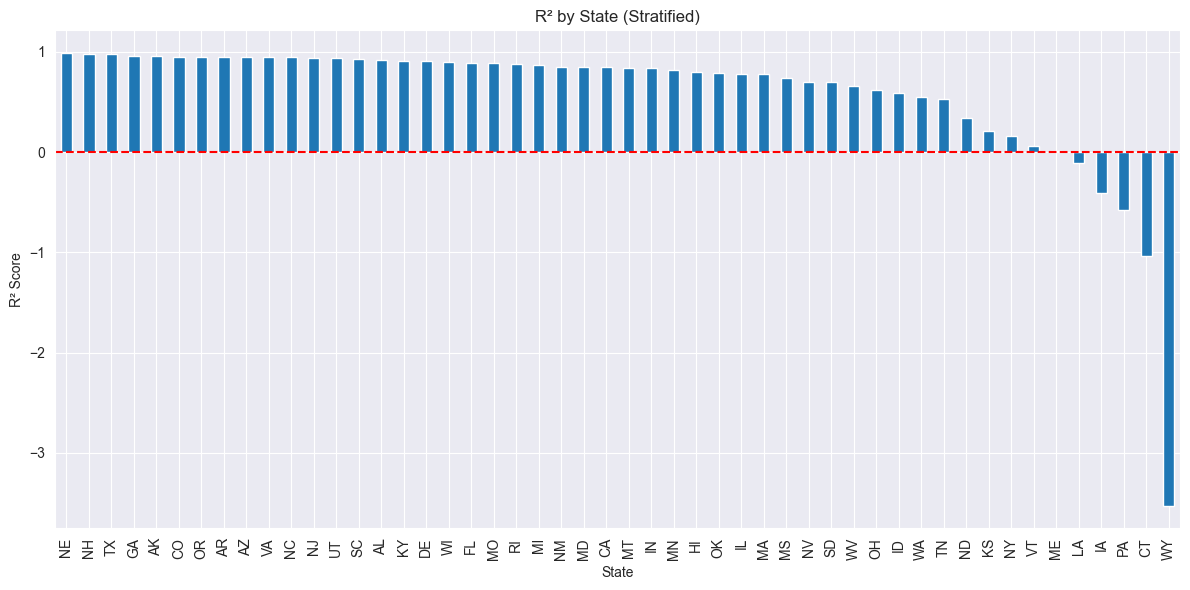

In [40]:
mse_rf, r2_rf, elapsed_time_rf, feature_importance_rf, stratified_r2_rf, r2_by_state_rf = train_rf_model_default(final_df_imputed)


Top 10 states by R²: ['NE', 'NH', 'TX', 'GA', 'AK', 'CO', 'OR', 'AR', 'AZ', 'VA']

Average Feature Importance Across Top States:
population                 0.796814
political_party            0.094894
party_affiliation_score    0.074753
Policy Scores              0.033539
size                       0.000000
dtype: float64


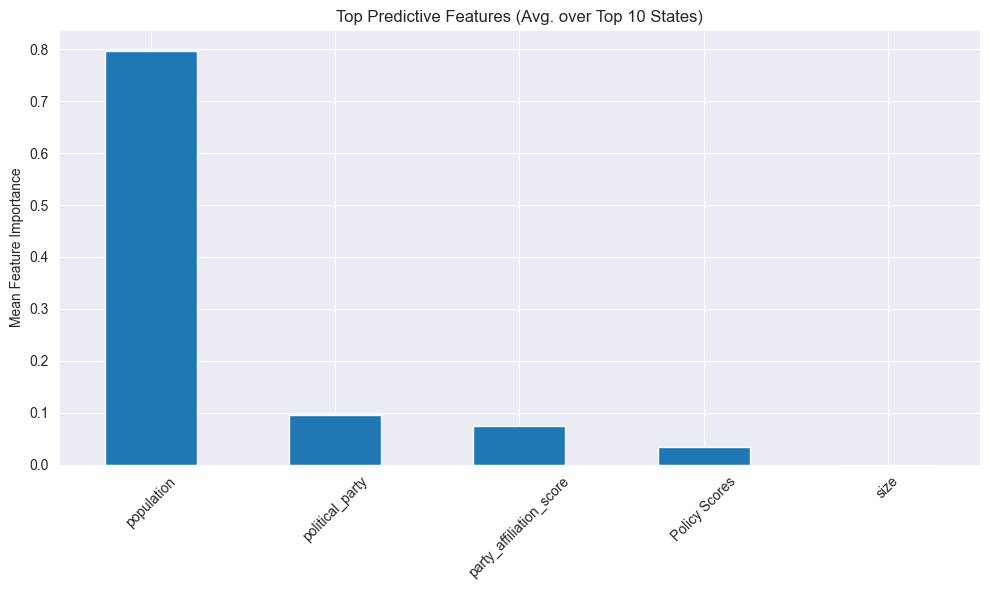

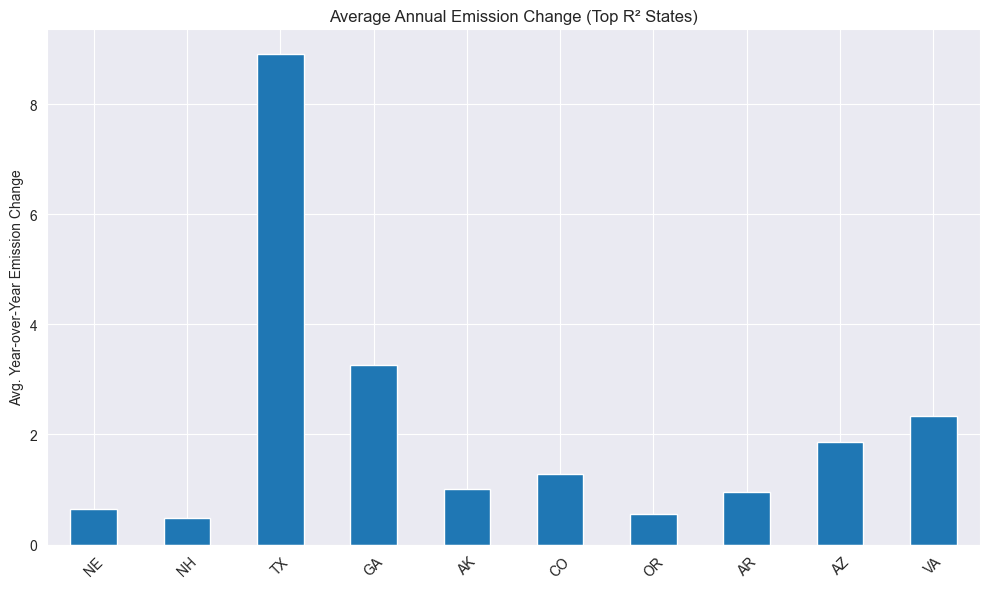

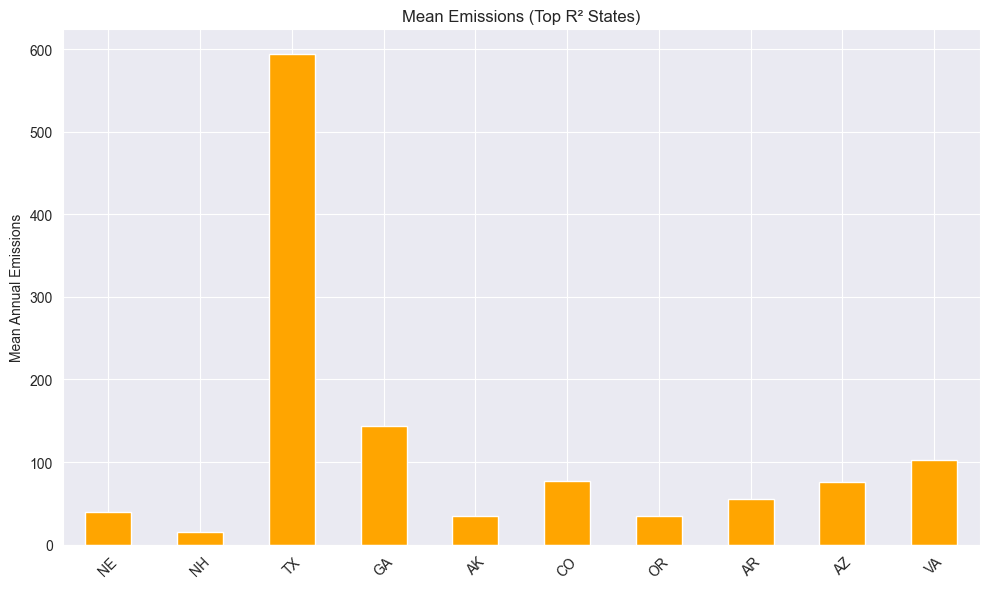

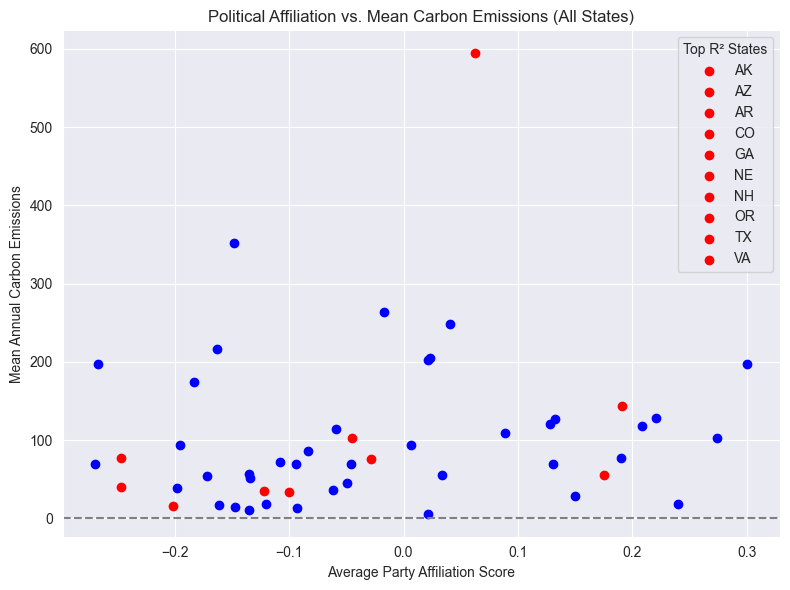

In [41]:
feature_scores, trend_df = analyze_top_states_by_r2(
    r2_by_state=r2_by_state_rf,
    df=final_df_imputed,
    model=RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42),
    top_k=10
)

Mean Squared Error: 17.4913
R² Score: 0.9981
Explained Variance Score: 0.99808025932731
Time taken: 0.2309 seconds

Feature Importance:
                   Feature  Importance
1               population    0.883169
2                     size    0.079224
0            Policy Scores    0.020792
3  party_affiliation_score    0.007490
5          political_party    0.006419
4  party_affiliation_score    0.002906

Stratified R² (average across states): -2.273712276353831
Highest R² by state: HI (0.9996129460459192)
Lowest R² by state: IA (-42.70785041280114)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


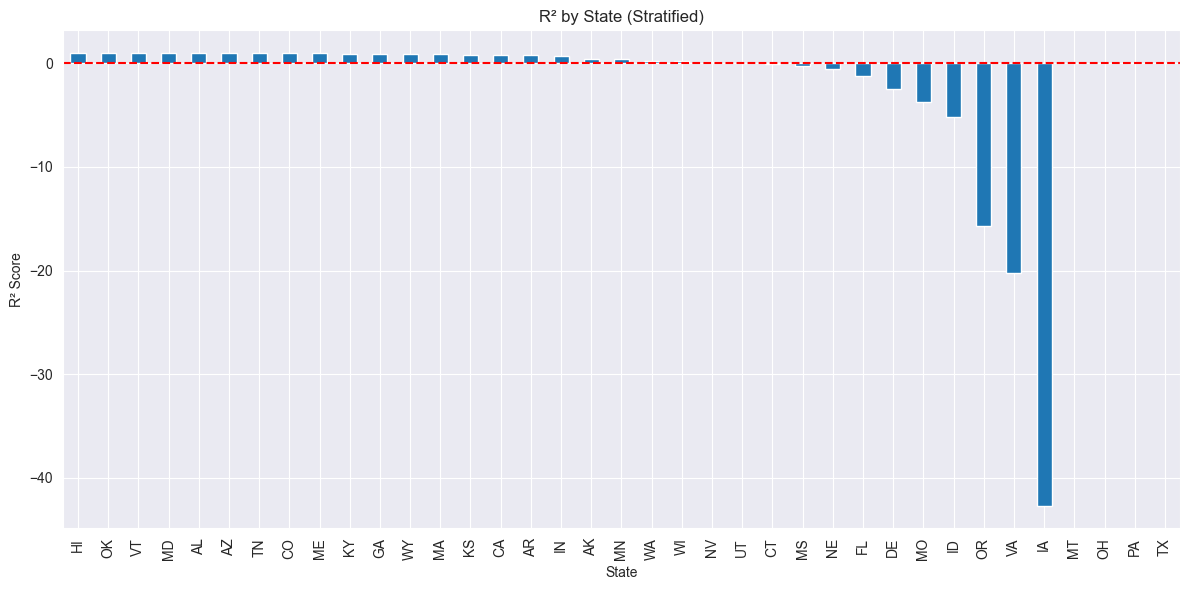

In [42]:
mse_rf, r2_rf, elapsed_time_rf, feature_importance_rf, stratified_r2_rf, r2_by_state_rf = train_rf_model_default(final_df_dropped)


Top 10 states by R²: ['HI', 'OK', 'VT', 'MD', 'AL', 'AZ', 'TN', 'CO', 'ME', 'KY']

Average Feature Importance Across Top States:
population                 0.451867
Policy Scores              0.279708
political_party            0.142471
party_affiliation_score    0.125954
size                       0.000000
dtype: float64


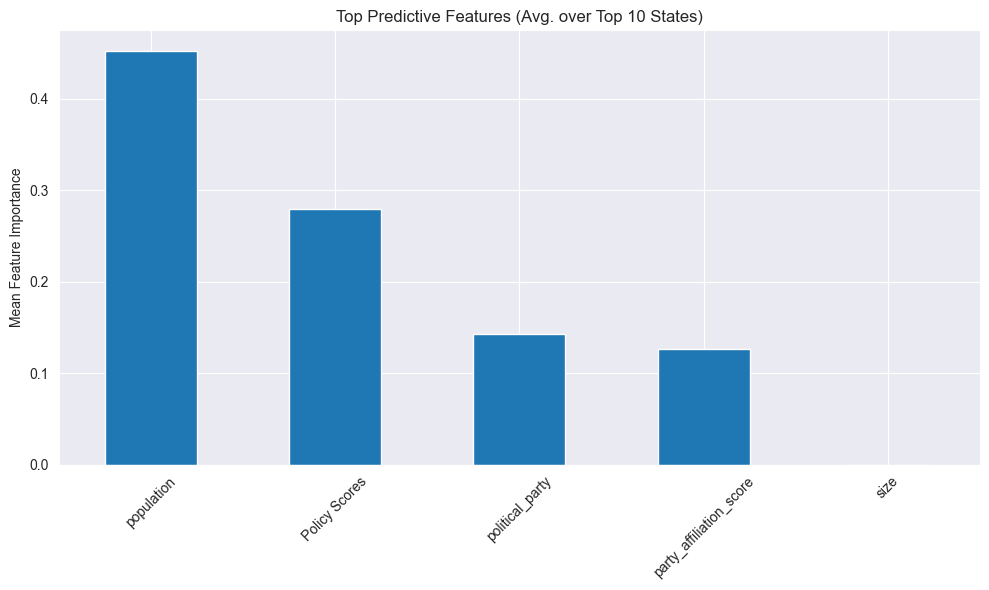

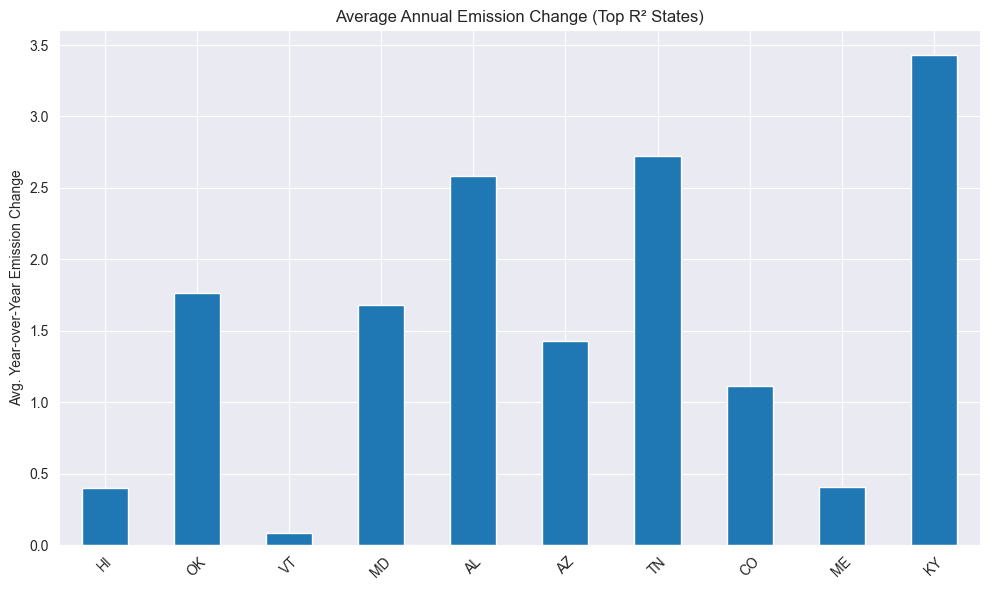

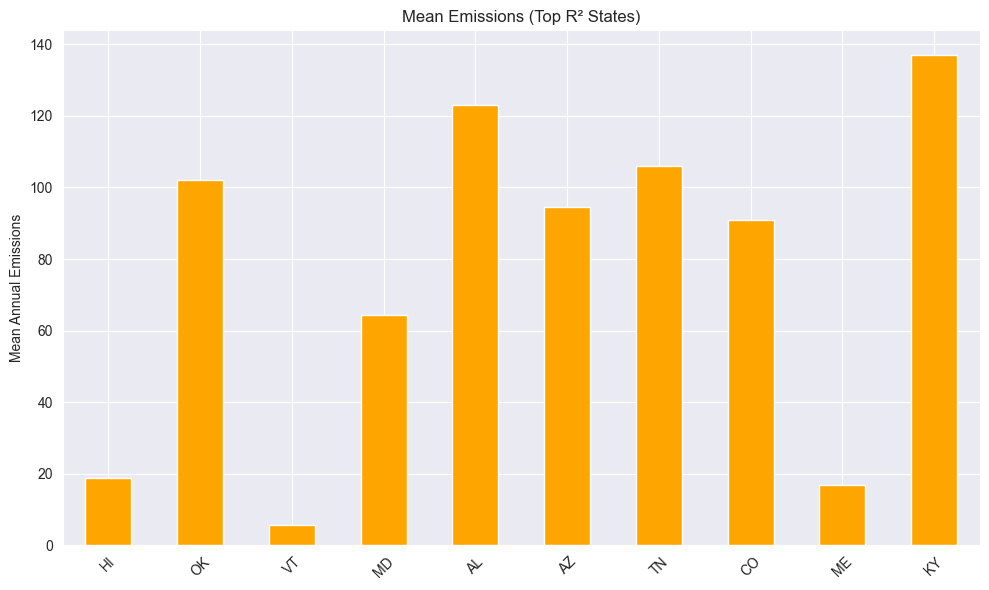

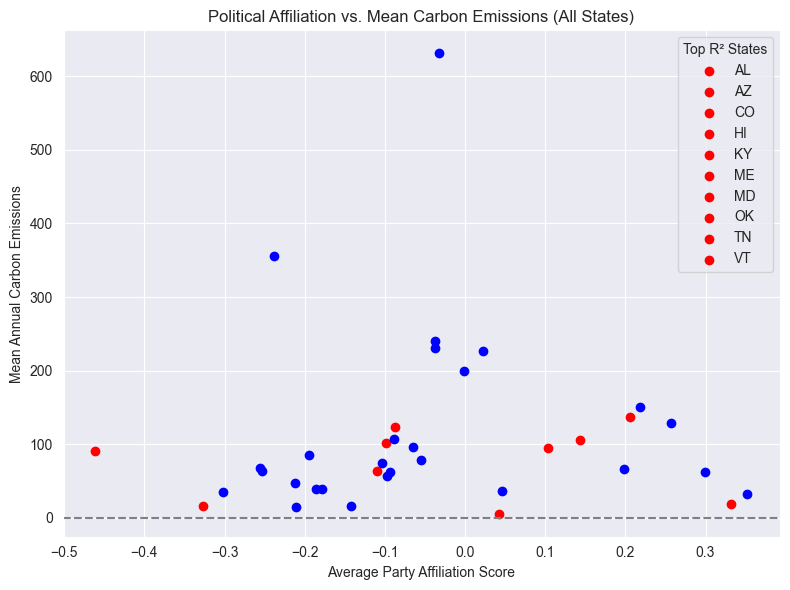

In [43]:
feature_scores, trend_df = analyze_top_states_by_r2(
    r2_by_state=r2_by_state_rf,
    df=final_df_dropped,
    model=RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42),
    top_k=10
)

### Future Predictions

This code splits the data into 10-year intervals and trains a Random Forest model to predict emissions for each interval. It calculates predictions and compares them with actual emissions, evaluating the model's performance using Mean Squared Error (MSE) and R² score. The actual and predicted emissions are plotted over the years, and the model performance metrics are displayed. The final output is a DataFrame showing the actual and predicted emissions for each year.

In [44]:
def train_random_forest(df, window_size, n_splits=5):
    try:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')

        if 'state' not in df.columns:
            print("No 'state' column found!")
            return

        df = df.sort_values(['state', 'year'])

        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()
        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)] + \
                   ['Policy Scores', 'population', 'size', 'party_affiliation_score']

        X = df[features]
        y = df['emissions']

        tscv = TimeSeriesSplit(n_splits=n_splits)
        r2_scores = []
        mse_scores = []
        explained_scores = []

        plt.figure(figsize=(10, 6))

        for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
            rf_model.fit(X_train, y_train)
            y_pred = rf_model.predict(X_test)

            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            explained_var = explained_variance_score(y_test, y_pred)

            print(f"Fold {fold} — R²: {r2:.4f}, MSE: {mse:.4f}, Explained Variance: {explained_var:.4f}")
            r2_scores.append(r2)
            mse_scores.append(mse)
            explained_scores.append(explained_var)

            # Plot actual vs predicted for this fold
            plt.scatter(y_test, y_pred, label=f'Fold {fold}', alpha=0.6)

        min_val = min(y.min(), y.max())
        max_val = max(y.min(), y.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')

        plt.xlabel('Actual Emissions')
        plt.ylabel('Predicted Emissions')
        plt.title('Random Forest Forecasting: Actual vs Predicted Emissions')
        plt.legend(title='Fold')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\nAverage R² Score: {np.mean(r2_scores):.4f}")
        print(f"Average Mean Squared Error: {np.mean(mse_scores):.4f}")
        print(f"Average Explained Variance Score: {np.mean(explained_scores):.4f}")

        feature_importances = rf_model.feature_importances_
        feature_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

        return r2_scores, mse_scores, explained_scores, feature_df

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Debugging details:")
        print(f"DataFrame shape before: {df.shape}")
        print(f"Columns: {df.columns}")
        print(f"window_size: {window_size}")


#### Imputed

Shape after sliding window processing: (2200, 9)
Fold 1 — R²: 0.9219, MSE: 491.5217, Explained Variance: 0.9363
Fold 2 — R²: 0.9976, MSE: 7.7779, Explained Variance: 0.9978
Fold 3 — R²: 0.9976, MSE: 5.7571, Explained Variance: 0.9979
Fold 4 — R²: 0.9929, MSE: 63.4611, Explained Variance: 0.9936
Fold 5 — R²: 0.7972, MSE: 6240.4295, Explained Variance: 0.8195


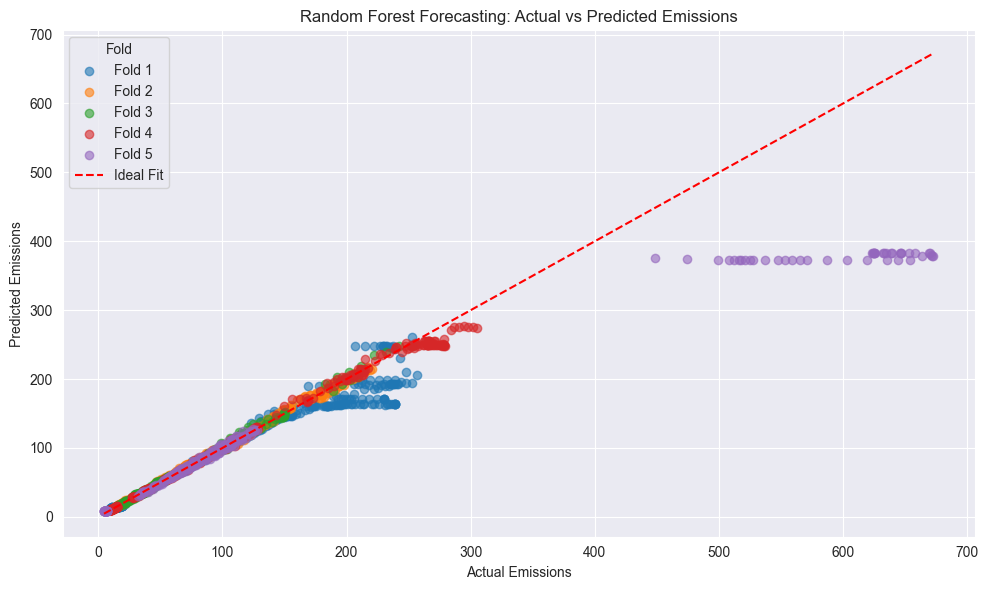


Average R² Score: 0.9415
Average Mean Squared Error: 1361.7895
Average Explained Variance Score: 0.9490


([0.9218720108806964,
  0.9976172872937918,
  0.9976445298508513,
  0.9929466431607292,
  0.7972422004595127],
 [491.5216665701847,
  7.777866705001023,
  5.7570966340862855,
  63.461123657213435,
  6240.42953519162],
 [0.9363092903586541,
  0.9978205147782833,
  0.9978684335559405,
  0.9935743748681306,
  0.8194583359015704],
                    Feature  Importance
 0      emissions_t_minus_1    0.993872
 3                     size    0.002880
 2               population    0.002831
 4  party_affiliation_score    0.000286
 1            Policy Scores    0.000130)

In [45]:
train_random_forest(final_df_imputed, 1)

Shape after sliding window processing: (2000, 13)
Fold 1 — R²: 0.9550, MSE: 286.1427, Explained Variance: 0.9616
Fold 2 — R²: 0.9979, MSE: 6.7564, Explained Variance: 0.9980
Fold 3 — R²: 0.9981, MSE: 4.3635, Explained Variance: 0.9982
Fold 4 — R²: 0.9930, MSE: 61.0883, Explained Variance: 0.9934
Fold 5 — R²: 0.7920, MSE: 6602.6745, Explained Variance: 0.8151


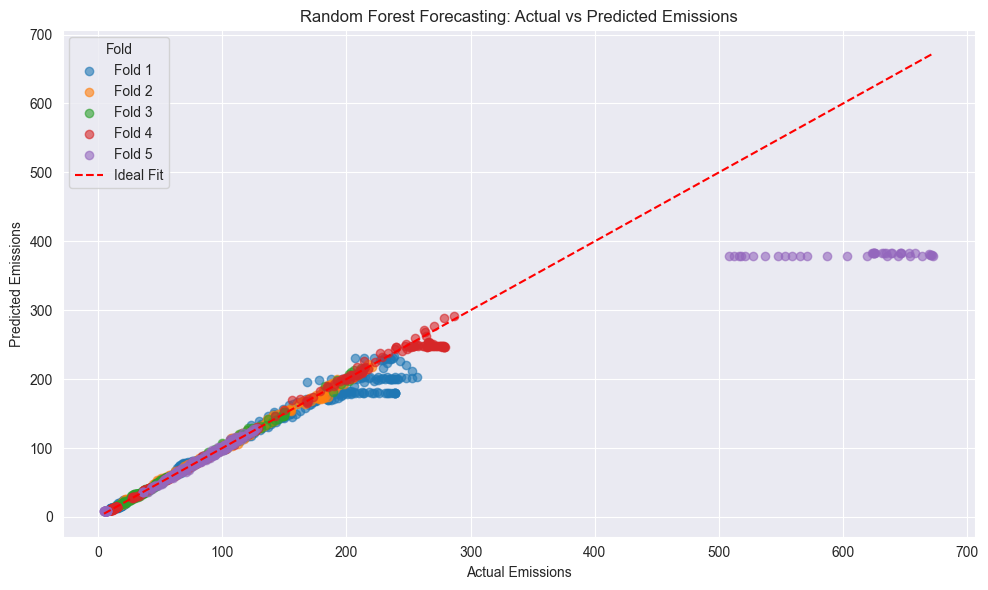


Average R² Score: 0.9472
Average Mean Squared Error: 1392.2051
Average Explained Variance Score: 0.9533


([0.95499546577921,
  0.997903375253938,
  0.9980771209321951,
  0.9929713605811087,
  0.7919509815803625],
 [286.1426935019659,
  6.756444327237913,
  4.363479573218463,
  61.08827914170142,
  6602.674479085364],
 [0.9615681311820723,
  0.9979742188882794,
  0.9982302688024455,
  0.9934438086491092,
  0.8150502444820052],
                    Feature  Importance
 4      emissions_t_minus_1    0.990455
 3      emissions_t_minus_2    0.002838
 1      emissions_t_minus_4    0.001835
 2      emissions_t_minus_3    0.001437
 7                     size    0.001365
 6               population    0.001127
 0      emissions_t_minus_5    0.000745
 8  party_affiliation_score    0.000134
 5            Policy Scores    0.000064)

In [46]:
train_random_forest(final_df_imputed, 5)

Shape after sliding window processing: (1750, 18)
Fold 1 — R²: 0.9785, MSE: 137.1361, Explained Variance: 0.9809
Fold 2 — R²: 0.9976, MSE: 7.9563, Explained Variance: 0.9976
Fold 3 — R²: 0.9981, MSE: 4.4687, Explained Variance: 0.9981
Fold 4 — R²: 0.9913, MSE: 73.8526, Explained Variance: 0.9919
Fold 5 — R²: 0.7724, MSE: 7512.5695, Explained Variance: 0.7981


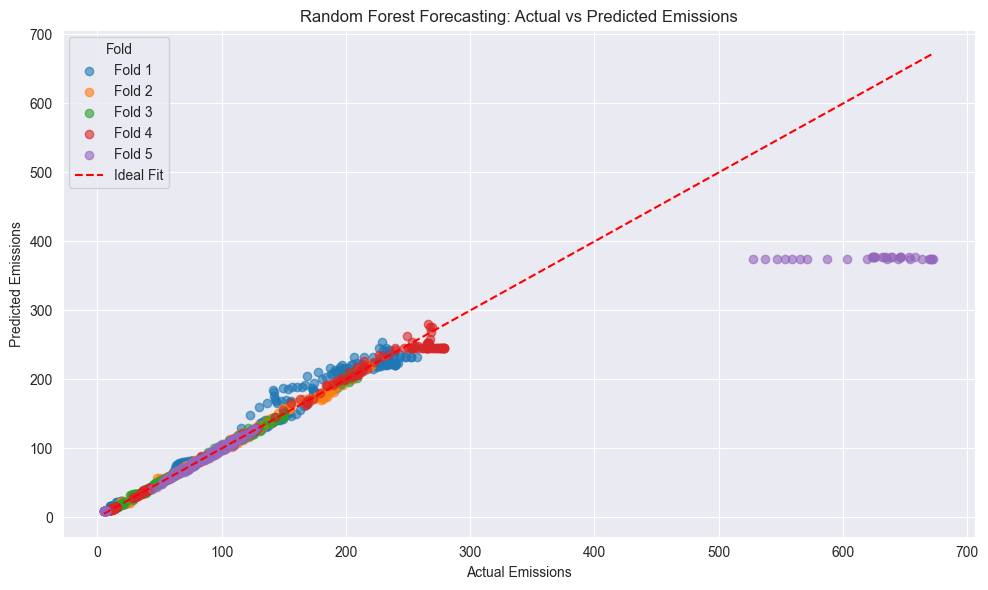


Average R² Score: 0.9476
Average Mean Squared Error: 1547.1966
Average Explained Variance Score: 0.9533


([0.9784625945530622,
  0.997563024324906,
  0.9980770509581081,
  0.9913189185780003,
  0.772370579420152],
 [137.13609076859257,
  7.956281014056089,
  4.468730330649889,
  73.85255482315219,
  7512.5694762942085],
 [0.9809435934799748,
  0.9975759152564778,
  0.9981141882339004,
  0.9918943495417053,
  0.7981176078983931],
                     Feature  Importance
 9       emissions_t_minus_1    0.988182
 7       emissions_t_minus_3    0.002868
 12                     size    0.001939
 2       emissions_t_minus_8    0.001301
 4       emissions_t_minus_6    0.001083
 0      emissions_t_minus_10    0.001023
 1       emissions_t_minus_9    0.000960
 8       emissions_t_minus_2    0.000892
 11               population    0.000863
 6       emissions_t_minus_4    0.000343
 3       emissions_t_minus_7    0.000263
 13  party_affiliation_score    0.000126
 10            Policy Scores    0.000090
 5       emissions_t_minus_5    0.000068)

In [47]:
train_random_forest(final_df_imputed, 10)

#### Non-imputed

Shape after sliding window processing: (592, 9)
Fold 1 — R²: 0.5841, MSE: 2651.6342, Explained Variance: 0.5874
Fold 2 — R²: 0.9889, MSE: 40.6776, Explained Variance: 0.9901
Fold 3 — R²: 0.9952, MSE: 5.6646, Explained Variance: 0.9955
Fold 4 — R²: 0.5755, MSE: 15126.9268, Explained Variance: 0.6480
Fold 5 — R²: 0.9976, MSE: 17.7552, Explained Variance: 0.9976


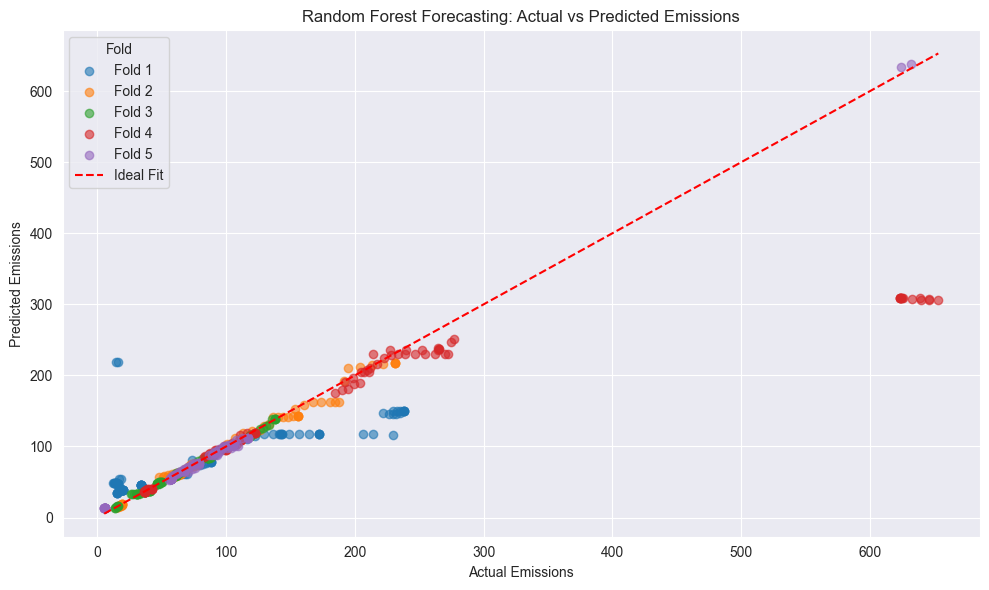


Average R² Score: 0.8283
Average Mean Squared Error: 3568.5317
Average Explained Variance Score: 0.8437


([0.5841485484085256,
  0.9889294815303015,
  0.9952264154422822,
  0.5754663992630596,
  0.9975836706938744],
 [2651.634190228187,
  40.6776010542643,
  5.664642130642768,
  15126.926827636229,
  17.75521986502715],
 [0.587407954620878,
  0.9900634316154268,
  0.99551508245365,
  0.6479926882715378,
  0.9975893177216897],
                    Feature  Importance
 0      emissions_t_minus_1    0.778644
 2               population    0.128032
 3                     size    0.080618
 1            Policy Scores    0.010093
 4  party_affiliation_score    0.002613)

In [48]:
train_random_forest(final_df_dropped, 1)

Shape after sliding window processing: (444, 13)
Fold 1 — R²: 0.6043, MSE: 2373.7421, Explained Variance: 0.6082
Fold 2 — R²: 0.9882, MSE: 37.9029, Explained Variance: 0.9884
Fold 3 — R²: 0.9869, MSE: 15.1518, Explained Variance: 0.9899
Fold 4 — R²: 0.6354, MSE: 12747.5594, Explained Variance: 0.6911
Fold 5 — R²: 0.9975, MSE: 22.7898, Explained Variance: 0.9976


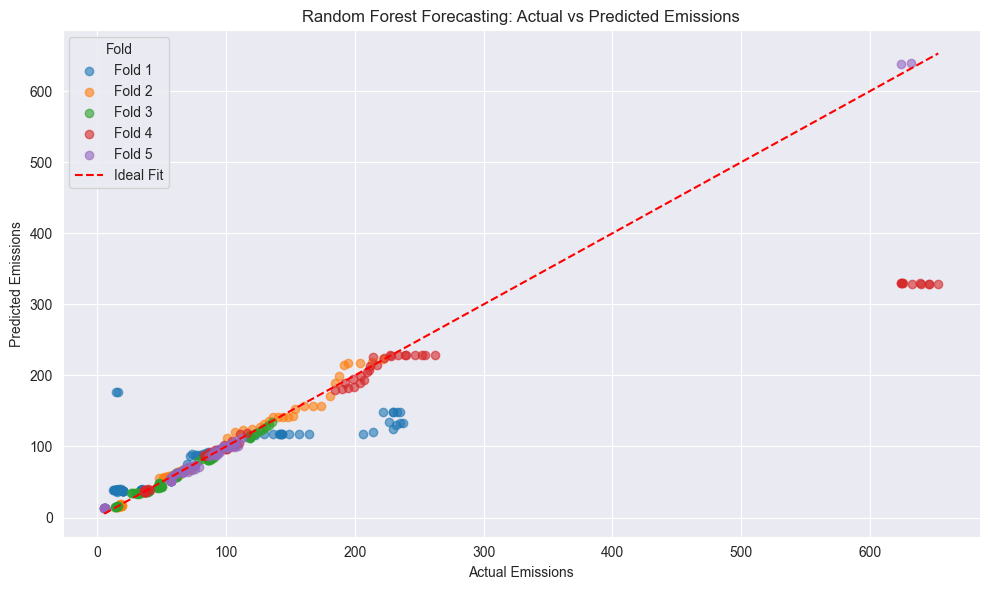


Average R² Score: 0.8425
Average Mean Squared Error: 3039.4292
Average Explained Variance Score: 0.8550


([0.6042880277258973,
  0.9882208356821917,
  0.9869376763033891,
  0.6354125399274109,
  0.997546985554024],
 [2373.742058582773,
  37.90293439594033,
  15.151820002110156,
  12747.559390194154,
  22.789816195536442],
 [0.608226042304105,
  0.9883785525526495,
  0.9899494331602654,
  0.6910954110520635,
  0.9975637198382515],
                    Feature  Importance
 4      emissions_t_minus_1    0.293633
 3      emissions_t_minus_2    0.229222
 6               population    0.133289
 1      emissions_t_minus_4    0.107730
 0      emissions_t_minus_5    0.101240
 2      emissions_t_minus_3    0.086286
 7                     size    0.027233
 5            Policy Scores    0.016648
 8  party_affiliation_score    0.004719)

In [49]:
train_random_forest(final_df_dropped, 5)

Shape after sliding window processing: (259, 18)
Fold 1 — R²: 0.6599, MSE: 1983.2137, Explained Variance: 0.6643
Fold 2 — R²: 0.9709, MSE: 76.8747, Explained Variance: 0.9761
Fold 3 — R²: 0.9736, MSE: 28.1099, Explained Variance: 0.9819
Fold 4 — R²: 0.6089, MSE: 14332.3008, Explained Variance: 0.6609
Fold 5 — R²: 0.9943, MSE: 45.9782, Explained Variance: 0.9952


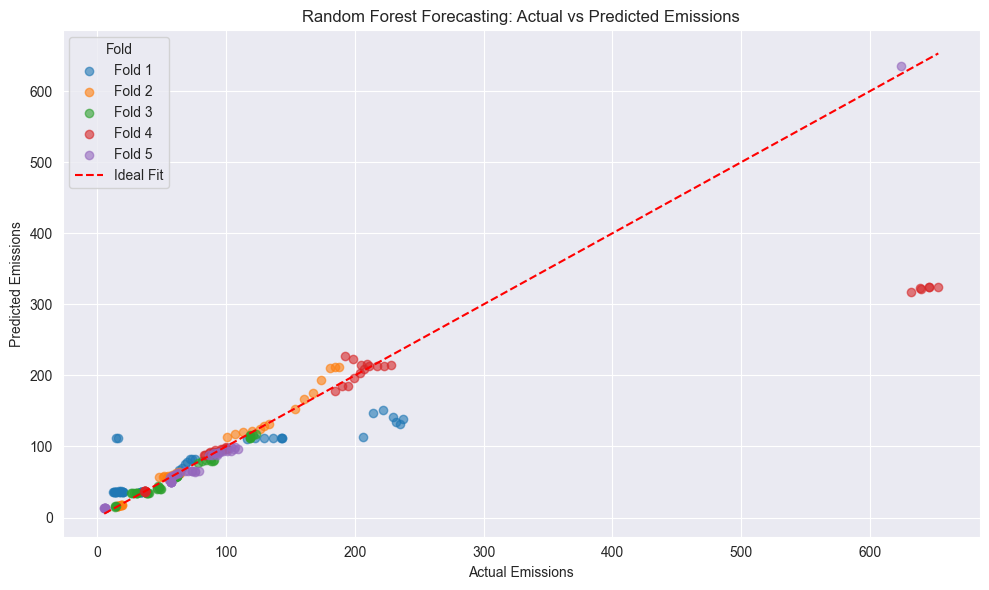


Average R² Score: 0.8415
Average Mean Squared Error: 3293.2955
Average Explained Variance Score: 0.8557


([0.6598675023461775,
  0.9709407904845905,
  0.9735903494052842,
  0.608906373287734,
  0.994305390161611],
 [1983.2136755461672,
  76.87466873082495,
  28.109908275612334,
  14332.30080259495,
  45.97821102837506],
 [0.6643240798120762,
  0.9760787909165997,
  0.981899210001435,
  0.6609152580718047,
  0.9951931407663412],
                     Feature  Importance
 9       emissions_t_minus_1    0.134512
 11               population    0.123521
 8       emissions_t_minus_2    0.118913
 5       emissions_t_minus_5    0.091040
 3       emissions_t_minus_7    0.090110
 2       emissions_t_minus_8    0.087233
 4       emissions_t_minus_6    0.082012
 7       emissions_t_minus_3    0.081881
 6       emissions_t_minus_4    0.065758
 1       emissions_t_minus_9    0.050673
 0      emissions_t_minus_10    0.048345
 12                     size    0.012676
 10            Policy Scores    0.010097
 13  party_affiliation_score    0.003228)

In [50]:
train_random_forest(final_df_dropped, 10)

#### Using Feature Engineering

In [51]:
for df_name in ['final_df_dropped_normalized', 'final_df_dropped', 'final_df_imputed_normalized', 'final_df_imputed']:
    df = globals()[df_name]
    df['emissions_per_person_per_sq_mile'] = df['emissions'] / (df['population'] * df['size'])
    globals()[df_name] = df


In [52]:

def run_logistic_model(df):
    label_encoder = LabelEncoder()
    df = df.dropna(subset=['state', 'year', 'Policy Scores', 'emissions_per_person_per_sq_mile', 'political_party'])
    df['state'] = label_encoder.fit_transform(df['state'])
    df['political_party'] = label_encoder.fit_transform(df['political_party'])

    X = df[['state', 'year', 'Policy Scores', 'emissions_per_person_per_sq_mile']]
    y = df['political_party']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)

    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    print(f'Accuracy: {acc}')
    print("\nClassification Report:")
    print("\nFeature Coefficients:")
    print(coef_df)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix: Logistic Regression')
    plt.show()

    return acc, coef_df

In [53]:
def run_simple_lr(df):
    label_encoder = LabelEncoder()
    df = df.dropna(subset=['state', 'year', 'Policy Scores', 'emissions_per_person_per_sq_mile', 'political_party'])
    df['state'] = label_encoder.fit_transform(df['state'])
    df['political_party'] = label_encoder.fit_transform(df['party_affiliation_score'])

    X = df[['state', 'year', 'Policy Scores', 'emissions_per_person_per_sq_mile']]
    y = df['political_party']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    print(f'Mean Squared Error: {mse}')
    print(f'R² Score: {r2}')
    print("\nFeature Coefficients:")
    print(coef_df)

    # plt.figure(figsize=(8, 6))
    # plt.scatter(y_test, y_pred, alpha=0.7)
    # z = np.polyfit(y_test, y_pred, 1)
    # p = np.poly1d(z)
    # plt.plot(y_test, p(y_test), "r--", label='Regression Line')
    # plt.xlabel('Actual Political Party (Encoded)')
    # plt.ylabel('Predicted')
    # plt.title('Linear Regression: Actual vs Predicted Political Party')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return mse, r2, coef_df


In [54]:
mse, r2, coef_df = run_simple_lr(final_df_imputed_normalized)

Mean Squared Error: 421271.8171399867
R² Score: -0.01928414155262348

Feature Coefficients:
                            Feature  Coefficient
2                     Policy Scores   -27.013557
1                              year    -8.058629
0                             state    -1.997282
3  emissions_per_person_per_sq_mile     0.000052


In [ ]:
acc, coef_df = run_logistic_model(final_df_imputed_normalized)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.02666666666666667

Classification Report:

Feature Coefficients:
                            Feature   Coefficient
3  emissions_per_person_per_sq_mile -4.477720e-04
1                              year  1.142318e-04
0                             state  6.873431e-06
2                     Policy Scores  7.378039e-10


In [ ]:
def run_random_forest_classifier(df):
    label_encoder = LabelEncoder()
    df = df.dropna(subset=['state', 'year', 'Policy Scores', 'emissions_per_person_per_sq_mile', 'political_party'])
    df['state'] = label_encoder.fit_transform(df['state'])
    df['political_party'] = label_encoder.fit_transform(df['political_party'])

    X = df[['state', 'year', 'Policy Scores', 'emissions_per_person_per_sq_mile']]
    y = df['political_party']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print(f'Accuracy: {acc}')
    print("\nClassification Report:")
    print("\nFeature Importances:")
    print(feature_importance_df)

    return acc, feature_importance_df

In [ ]:
def run_random_forest_regressor(df):
    label_encoder = LabelEncoder()
    df = df.dropna(subset=['state', 'year', 'Policy Scores', 'emissions_per_person_per_sq_mile', 'political_party'])
    df['state'] = label_encoder.fit_transform(df['state'])
    df['political_party'] = label_encoder.fit_transform(df['party_affiliation_score'])

    X = df[['state', 'year', 'Policy Scores', 'emissions_per_person_per_sq_mile']]
    y = df['political_party']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)

    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R² Score: {r2:.4f}')
    print(f'Explained Variance Score: {explained_var:.4f}')
    print("\nFeature Importances:")
    print(feature_importance_df)

    # plt.figure(figsize=(8, 6))
    # plt.scatter(y_test, y_pred, alpha=0.7)
    # z = np.polyfit(y_test, y_pred, 1)
    # p = np.poly1d(z)
    # plt.plot(y_test, p(y_test), "r--", label='Regression Line')
    # plt.xlabel('Actual Political Party (Encoded)')
    # plt.ylabel('Predicted')
    # plt.title('Random Forest Regression: Actual vs Predicted Political Party')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return mse, r2, explained_var, feature_importance_df


In [ ]:
mse, r2, explained_var, feature_importance_df = run_random_forest_regressor(final_df_imputed)

In [ ]:
acc, feature_importance_df = run_random_forest_classifier(final_df_imputed)

### Unsupervised Analysis

This code creates a new column, "political_party," in the `final_df_imputed` DataFrame. It assigns the value 'D' (Democrat) if the "final_score_avg" is greater than 0, and 'R' (Republican) if it is less than or equal to 0. The resulting DataFrame reflects the political party assignment based on the final scores.

In [ ]:
final_df_imputed_normalized['political_party'] = final_df_imputed_normalized['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
final_df_imputed_normalized

In [ ]:
final_df_dropped_normalized['political_party'] = final_df_dropped_normalized['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')

final_df_dropped_normalized

This code processes the data by assigning political party labels based on the `party_affiliation_score` and then performs Principal Component Analysis (PCA) to reduce the data to two components, visualizing the results in a scatter plot with political party color coding. It then trains a Support Vector Machine (SVM) classifier using the two PCA components to predict political party affiliation, evaluating the model with accuracy and a confusion matrix, and visualizing the confusion matrix with a heatmap. Additionally, the code calculates and visualizes the correlation matrix for selected features to assess their relationships and calculates the Variance Inflation Factor (VIF) to check for multicollinearity among the features, providing insights into potential issues in the dataset.

In [ ]:
def analyze_political_party(df):
    if 'party_affiliation_score' not in df.columns:
        df['party_affiliation_score'] = 0

    if 'political_party' not in df.columns:
        df['political_party'] = df['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
    else:
        df['political_party'] = df['political_party'].fillna(
            df['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
        )

    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score']]
    y = df['political_party']

    X_scaled = StandardScaler().fit_transform(X)

    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_scaled, y)

    y_pred = svm_model.predict(X_scaled)

    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Democrat', 'Republican'],
                yticklabels=['Democrat', 'Republican'])
    plt.title('Confusion Matrix')
    plt.show()

    correlation_matrix = df[['Policy Scores', 'population', 'size', 'party_affiliation_score']].corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

    X_with_const = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X_with_const.columns
    vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    print(vif_data)

#### Imputed

In [ ]:
without_party_score_df = final_df_imputed_normalized.drop(columns='party_affiliation_score')

In [ ]:
analyze_political_party(final_df_imputed_normalized)

In [ ]:
analyze_political_party(without_party_score_df)

#### Non-imputed

In [ ]:
without_party_score_df = final_df_dropped_normalized.drop(columns='party_affiliation_score')

In [ ]:
analyze_political_party(final_df_dropped_normalized)

In [ ]:
analyze_political_party(without_party_score_df)